### Product Recommendation Systems

### Domain - E-commerce

### Context
##### Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites.

### Data Description
##### Data columns- First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

### Learning Outcomes
- Exploratory Data Analysis
- Data Wrangling
- Build a Popularity recommender model
- Build Collaborative Filtering model

### Objective
- To make a recommendation system that recommends at least five(5) new products based on the user's habits.

In [276]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time
#from sklearn.externals import joblib
import joblib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import requests
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering
from surprise import accuracy
from surprise.model_selection import KFold

In [167]:
#!pip install joblib

In [168]:
#!pip install gdown

In [169]:
#for downloading data from google drive directly to pandas for large file exceptions
import gdown

#### Importing Data from Google Drive

https://drive.google.com/u/0/uc?export=download&confirm=FwWj&id=1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW
https://drive.google.com/u/0/uc?export=download&confirm=FwWj&id=1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW
https://drive.google.com/u/0/uc?export=download&confirm=xYPC&id=1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW
https://drive.google.com/u/0/open?id=1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW

In [170]:
sharedUrl='https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing'
dwd_url='https://drive.google.com/uc?export=download&id=' + sharedUrl.split('/')[-2]


In [171]:
#output='downloaded_Amazon_data.csv'
#gdown.download(dwd_url,output,quiet=False)

In [172]:
#csv file has no header provided, so have to read with header option as none and insert column names later
#df=pd.read_csv(gdown.download(dwd_url),header=None)

In [173]:
#data is downloaded and saved in local to avoid network usage every time we execute the file
df=pd.read_csv('downloaded_Amazon_data.csv',header=None)

##### Exploring Data

In [174]:
#Peaking on intital data
df.head()

0           1    2           3
0   AKM1MP6P0OYPR  0132793040  5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944  5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341  1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341  3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341  1.0  1334707200

#### Inserting Column Names

In [175]:
# inserting column names
df.columns=['userId', 'productId', 'ratings', 'timestamp']

### Exploring the given data set

In [176]:
df.shape


(7824482, 4)

- 4 columns and 7,824,482 rows

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


- 4 columns
- User Id and Product ID are alphanumeric ID columns on users and products hence type is object
- Ratings range from 1-5 and is represented in 1.0 to 5.0 hence a float. we can try to covert it from float to int to reduce memory footprint.
- Timestamp is a epoch format hence int64.

In [178]:
df.ratings=df.ratings.astype('uint8')

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     object
 1   productId  object
 2   ratings    uint8 
 3   timestamp  int64 
dtypes: int64(1), object(2), uint8(1)
memory usage: 186.6+ MB


- As we can see the memory usage is reduced from 239 MB to 187 MB, after changing Dtype to uint8
- uint8 - 	Unsigned integer (0 to 255)
- This is best suited for the data set as we have a range of 1-5 only

In [180]:
df.describe().T

count          mean           std          min           25%  \
ratings    7824482.0  4.012337e+00  1.380910e+00          1.0  3.000000e+00   
timestamp  7824482.0  1.338178e+09  6.900426e+07  912729600.0  1.315354e+09   

                    50%           75%           max  
ratings    5.000000e+00  5.000000e+00  5.000000e+00  
timestamp  1.361059e+09  1.386115e+09  1.406074e+09

- we can notice the min and max of ratings are 1 & 5 as expected with mean of 4 and median 5. This shows we have more presence of 4 and 5 in the data set.

In [181]:
#evaluating random samples 
df.sample(10)

userId   productId  ratings   timestamp
5384019   AKMT2EERVQZRS  B006GWO5WK        5  1356652800
2183504  A17Z4VIPO2TYSC  B001NXE0X6        5  1322179200
3661259  A2I3C34CXCUXZR  B003XMROKG        5  1324425600
4486667  A3BD30IIFWWDU7  B004UJF1GK        4  1381881600
2707118  A28C6IRIULNYKM  B002MAPRYU        2  1375574400
3962161   A8TPA3E3SN4O9  B0049MWYOK        5  1387324800
5628788   AZNFWFTM36XN7  B0075SUGQI        1  1369353600
3958164  A2V51I9L6AICZM  B0049I48JI        5  1394409600
6333383   A35DSO3DHBIFL  B008PIIQ8M        2  1350086400
6331597  A2H85E8TQTIC9W  B008PAH9TW        1  1382227200

- From Random selection we can notice the occurance of 5 & 4 is more compared to others

#### Null Value Analysis

In [182]:
df.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

- No null data found in data sets

#### Dropping Time stamp

In [183]:
#dropping timestamp and saving in other variable to keep DF untouched
azSet1Df=df.drop(columns=['timestamp'],axis=1)

In [184]:
azSet1Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     object
 1   productId  object
 2   ratings    uint8 
dtypes: object(2), uint8(1)
memory usage: 126.9+ MB


- Timestamp is non-relevent for current problem statement
- Memory reduced from 187 MB to 127 MB

In [185]:
azSet1Df.head()
azSet1Df.shape

userId   productId  ratings
0   AKM1MP6P0OYPR  0132793040        5
1  A2CX7LUOHB2NDG  0321732944        5
2  A2NWSAGRHCP8N5  0439886341        1
3  A2WNBOD3WNDNKT  0439886341        3
4  A1GI0U4ZRJA8WN  0439886341        1

(7824482, 3)

- Dropped Timestamp columns and we can verify in dataframes shape.

In [186]:
#Distribution of Ratings
azSet1Df['ratings'].value_counts()

5    4347541
4    1485781
1     901765
3     633073
2     456322
Name: ratings, dtype: int64

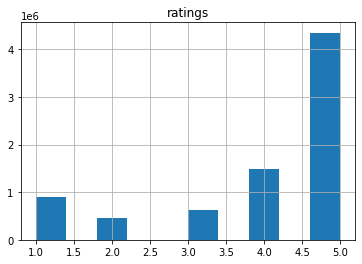

In [187]:
#visualize the pattern of ratings
azSet1Df.hist('ratings', bins=10);

- Majority of people have voted 5 for various products
- If we notice the total values most rated numbers are 5,4 and 1. 
- 2 & 3 are least choosen ratings respectively
- We need to evaluate on products which are purchased less/more to see what kind of ratings they have received to analyze

In [188]:
#total unique number of products
print('Total number of unique products:', azSet1Df['productId'].nunique())

Total number of unique products: 476002


In [189]:
#total number of Users
print('Total number of Users:', azSet1Df['userId'].nunique())

Total number of Users: 4201696


In [190]:
#top 10 most reviewed products
pd.DataFrame(azSet1Df.groupby('productId')['ratings'].count().sort_values(ascending=False).head(10))

ratings
productId          
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487

<AxesSubplot:xlabel='productId'>

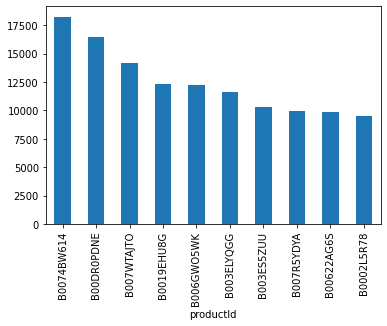

In [191]:
#visualize the top 10 product reviews
azSet1Df.groupby('productId')['ratings'].size().sort_values(ascending=False).head(10).plot(kind = "bar") 

In [192]:
#top 10 reviewers and their count details
azSet1Df.groupby('userId')['ratings'].count().sort_values(ascending=False).head(10)

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: ratings, dtype: int64

<AxesSubplot:xlabel='userId'>

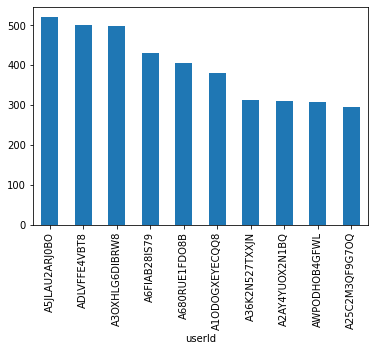

In [193]:
#visualize top 10 reviewers and their count details
azSet1Df.groupby('userId')['ratings'].count().sort_values(ascending=False).head(10).plot(kind = "bar")

In [194]:
#any user with no ratings
azSet1Df.groupby('userId')['ratings'].count().sort_values(ascending=True).head(10)


userId
A00000262KYZUE4J55XGL    1
A3AAXWDYVQ93SZ           1
A3AAXWHVCN6VOG           1
A3AAXX0N47FFP            1
A3AAXY0TMZS72Y           1
A3AAXZAK8EB9KG           1
A3AAY0GAXS0XNA           1
A3AAY3OP8Z7FTA           1
A3AAY5WI5T8HN5           1
A3AAYE1Y83YT2P           1
Name: ratings, dtype: int64

- there were no null values for ratings and we can not see any user sending blank reviews as well

In [195]:
#grouping data with product with there mean rating and rating counts
ratings_mean_count=pd.DataFrame(azSet1Df.groupby('productId')['ratings'].mean())
ratings_mean_count['ratings_count']=pd.DataFrame(azSet1Df.groupby('productId')['ratings'].count())
ratings_mean_count.head()
ratings_mean_count.sample(5)

ratings  ratings_count
productId                          
0132793040  5.000000              1
0321732944  5.000000              1
0439886341  1.666667              3
0511189877  4.500000              6
0528881469  2.851852             27

ratings  ratings_count
productId                          
B001W7B1P8  4.000000              1
B0043BPL7E  5.000000              1
B003U8G95Y  4.258065             31
B003L18SE0  4.800000              5
B00BIZ0EY8  1.647059             17

In [196]:
ratings_mean_count.sort_values(['ratings_count','ratings'],ascending=[False,False]).head(10)

ratings  ratings_count
productId                          
B0074BW614  4.491504          18244
B00DR0PDNE  3.931020          16454
B007WTAJTO  4.424005          14172
B0019EHU8G  4.754497          12285
B006GWO5WK  4.314657          12226
B003ELYQGG  4.392528          11617
B003ES5ZUU  4.704749          10276
B007R5YDYA  4.690926           9907
B00622AG6S  4.420136           9823
B0002L5R78  4.448614           9487

- Considering the whole data set, above is the top 10 highly reviewed product with there mean ratings
- We can also use this product details as recomendations based on whole data set for most purchased and reviewed data.
- With whole data set we might have many novice users who may provide higher or lower ratings without much analysis. Hence will fish out those users with lower reviews as well as the products which are reviewed just once as single review might not give us a view of the population on the product.

#### Subset of data set to make it less sparase/denser

- Truncating users as well as Products
- Keeping those userid which have more atleast more than 50 reviews as we can consider them vetrans for the product review and assuming they have gained more experience on revwing over time
- We will also remove those products which are rarely sold

In [197]:
AllUsers=azSet1Df.groupby('userId').count()
AllUsers.head()

productId  ratings
userId                                   
A00000262KYZUE4J55XGL          1        1
A000063614T1OE0BUSKUT          2        2
A00009182QVLSWIGHLS1B          1        1
A00009661LC9LQPGKJ24G          1        1
A00010809P09NUU6ZP6H           1        1

In [198]:
#choosing those users who has atleast 50 reviews under them
testUsers=AllUsers[AllUsers['ratings'] >= 50].index

#selecting those products which are reviwed more than 1
filter_prod = azSet1Df['productId'].value_counts() > 1
filter_prod = filter_prod[filter_prod].index


In [199]:
selectiveDf=azSet1Df[(azSet1Df['userId'].isin(testUsers)) & (azSet1Df['productId'].isin(filter_prod)) ]

In [200]:
selectiveDf.head(5)

userId   productId  ratings
94   A3BY5KCNQZXV5U  0594451647        5
118   AT09WGFUM934H  0594481813        3
177  A32HSNCNPRUMTR  0970407998        1
178  A17HMM1M7T9PJ1  0970407998        4
492  A3CLWR1UUZT6TG  0972683275        5

In [201]:
selectiveDf.shape
#Data frame is reduced by significant margin

(122942, 3)

In [202]:
selectiveDf['ratings'].value_counts()

5    69314
4    31663
3    11782
2     5254
1     4929
Name: ratings, dtype: int64

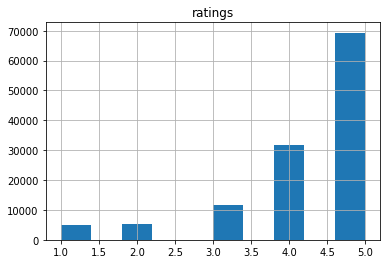

In [203]:
#visualize the pattern of ratings
selectiveDf.hist('ratings', bins=10);

- From the histogram we can notice the ratio for ratings are a lot diff from raw data
- We can still see rating 5 and 4 are dominated amon experienced reviewers as well but 1 & 2 are least on the reviews.

In [204]:
#validate the min ratings for a user id is more than 50
selectiveDf.groupby('userId')['ratings'].count().sort_values(ascending=True).head(10)

userId
A3MV1KKHX51FYT    33
AD8DLOGHAXL       41
A111WCUF5KA2I6    44
A3LSEIG2PIJYBL    44
A2UCDLO7V7DG6     44
A16CVJUQOB6GIB    44
A1R6RKKE44AYA8    45
A1XEQGYY1IL8CD    45
A32AK8FOAZEPE2    46
AY4EXFOO43C3S     46
Name: ratings, dtype: int64

In [205]:
df.where(df['userId'].isin(['A3MV1KKHX51FYT','AD8DLOGHAXL','A111WCUF5KA2I6'])).groupby('userId')['ratings'].count().sort_values(ascending=True)

userId
A3MV1KKHX51FYT    51
A111WCUF5KA2I6    52
AD8DLOGHAXL       69
Name: ratings, dtype: int64

- We can notice the values has less than 50 as we have also deleted the products which were reviewd only once hence reducing the number from original.
- Validated in original data sets these users infact has 50 reviews as minimum.

In [206]:
countFew=selectiveDf['userId'].nunique()
print('Number of unique users: ',countFew)

Number of unique users:  1540


In [207]:
countAll=df['userId'].nunique()

print('We have reduced total users from :',countAll,' to ',countFew )

We have reduced total users from : 4201696  to  1540


In [208]:
print('Percentage of users under test comparing to whole data set: ', (countFew/countAll)*100)

Percentage of users under test comparing to whole data set:  0.03665186629399176


- We are considering only 0.04% of total users for testing

In [209]:
countAll=df['productId'].nunique()
countFew=selectiveDf['productId'].nunique()
print('We have reduced total productId from :',countAll,' to ',countFew )

We have reduced total productId from : 476002  to  45261


In [210]:
print('Percentage of productId under test comparing to whole data set: ', (countFew/countAll)*100)

Percentage of productId under test comparing to whole data set:  9.508573493388683


- If we consider total products we are considering almost 10% of product and 0.04% of users from overall data set.
- We will try to increase the count of users capture a relatively higher representational number by decreasing our threshold.

#### decreasing threshold from 50 to 30

In [211]:
testUsers = azSet1Df['userId'].value_counts() >= 30
testUsers = testUsers[testUsers].index.tolist()
#testUsers=AllUsers[AllUsers['ratings'] >= 30].index


selectiveDf2=azSet1Df[(azSet1Df['userId'].isin(testUsers)) & (azSet1Df['productId'].isin(filter_prod)) ]

In [212]:
selectiveDf2.shape
#Data frame is reduced by significant margin

(256418, 3)

- We have now double the data now as we had with threshold of min 50 reviews

In [213]:
#validate the min ratings for a user id is more than 30
selectiveDf2.groupby('userId')['ratings'].count().sort_values(ascending=True).head(10)

userId
A18BMA5D7WJ5SA    11
A1ARG3ZBYC3HKL    20
A2T99E90CFQA7Q    22
A386ZN00XISN18    22
A2TCHRBAIPU5G3    22
A1M8H1OUVIJ2H7    22
A1I6U5AQAT3ZG9    23
AETYV6DS8XX2B     24
A1CSXI7MKL6UKR    24
A1ZBQ51X0X57LD    24
Name: ratings, dtype: int64

- We can see the numbers are below 30 as we noticed earlier for deletion of product as well as users.

In [214]:
df.where(df['userId'].isin(['A18BMA5D7WJ5SA','A1ARG3ZBYC3HKL','A2T99E90CFQA7Q'])).groupby('userId')['ratings'].count().sort_values(ascending=True)

userId
A2T99E90CFQA7Q    30
A1ARG3ZBYC3HKL    35
A18BMA5D7WJ5SA    48
Name: ratings, dtype: int64

- we can validate the new data frame created has only those users who have provided min of 30 reviews

In [215]:
#analyzing the distribution of ratings over products
selectiveDf2['ratings'].value_counts()

5    148198
4     60779
3     23960
1     12035
2     11446
Name: ratings, dtype: int64

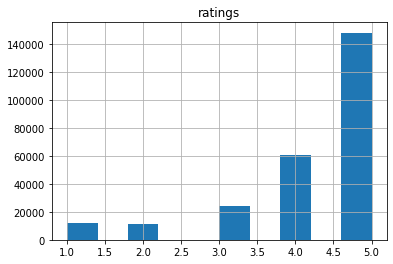

In [216]:
#visualize the pattern of ratings over products
selectiveDf2.hist('ratings', bins=10);

In [217]:
countAll=df['userId'].nunique()
countFew=selectiveDf2['userId'].nunique()
print('We have reduced total users from :',countAll,' to ',countFew )

We have reduced total users from : 4201696  to  5276


In [218]:
print('Percentage of users under test comparing to whole data set: ', (countFew/countAll)*100)

Percentage of users under test comparing to whole data set:  0.12556834192668864


- We are considering only 0.13% of total users for testing
- We have increased the user counts from 0.04% to 0.13%

In [219]:
countAll=df['productId'].nunique()
countFew=selectiveDf2['productId'].nunique()
print('We have reduced total productId from :',countAll,' to ',countFew )

We have reduced total productId from : 476002  to  74729


In [220]:
print('Percentage of productId under test comparing to whole data set: ', (countFew/countAll)*100)

Percentage of productId under test comparing to whole data set:  15.699303784437882


- Still not able to reach close to 10% of user base
- We will try at which level we are able to touch 10% of user base and wether its realistic to acheive these number or not

#### decreasing threshold from 30 to 10 to reach to 10% of user base

In [221]:
testUsers=AllUsers[AllUsers['ratings'] >= 10].index

In [222]:
selectiveDf3=azSet1Df[(azSet1Df['userId'].isin(testUsers)) & (azSet1Df['productId'].isin(filter_prod)) ]

In [223]:
selectiveDf3.sample(5)

userId   productId  ratings
6086609  A25TT44FXNV0F0  B0086CTL5Y        5
647783    A95PWI4S6WHGL  B0008ELUX4        5
3004626   A1TNDROOFUQ7G  B0031QNP8O        5
7328935  A34OXK9SP7TNCT  B00CXTF9HU        3
5367639   A8CKH8XB33XGN  B006EKIQYM        2

In [224]:
selectiveDf3.shape
#Data frame is reduced by significant margin

(1061048, 3)

In [225]:
#validate the min ratings for a user id is more than 4
selectiveDf3.groupby('userId')['ratings'].count().sort_values(ascending=True).head(10)

userId
A1GV9YKRGB4MSQ    1
A19FZ6LJDCO4Q     2
A2U38J8EIZQ29A    2
A39RVSTYALW9VZ    2
A1PB6OT0OOPKNQ    3
ANQN75TC5RL09     4
A1N2QHOYZBDPK6    4
A2JOVN3OCXAXWX    4
A2VSAW4G7EQ6BD    5
A2QRL5FSRPK4LM    5
Name: ratings, dtype: int64

In [226]:
df.where(df['userId'].isin(['A1GV9YKRGB4MSQ','A19FZ6LJDCO4Q','A2U38J8EIZQ29A'])).groupby('userId')['ratings'].count().sort_values(ascending=True)

userId
A19FZ6LJDCO4Q     11
A2U38J8EIZQ29A    13
A1GV9YKRGB4MSQ    15
Name: ratings, dtype: int64

- we can validate the new data frame created has only those users who have provided min of 4 reviews

In [227]:
countAll=df['userId'].nunique()
countFew=selectiveDf3['userId'].nunique()
print('We have reduced total users from :',countAll,' to ',countFew )

We have reduced total users from : 4201696  to  63175


In [228]:
print('Percentage of users under test comparing to whole data set: ', (countFew/countAll)*100)

Percentage of users under test comparing to whole data set:  1.5035595150148893


 - With 10 reviews also we are not reach towards the 10% of user base.
 - Going below 10 reviews will not be wise as it will add many novice users to the model.

In [229]:
countAll=df['productId'].nunique()
countFew=selectiveDf3['productId'].nunique()
print('We have reduced total productId from :',countAll,' to ',countFew )

We have reduced total productId from : 476002  to  164405


In [230]:
print('Percentage of productId under test comparing to whole data set: ', (countFew/countAll)*100)

Percentage of productId under test comparing to whole data set:  34.538720425544426


In [231]:
selectiveDf3['ratings'].value_counts()

5    627184
4    223889
3     92921
1     65802
2     51252
Name: ratings, dtype: int64

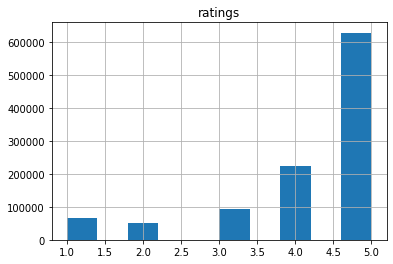

In [232]:
#visualize the pattern of ratings
selectiveDf3.hist('ratings', bins=10);

- Percentage of users under test comparing to whole data set:  1.5035595150148893 %
- Percentage of productId under test comparing to whole data set:  34.538720425544426 %
- Overall data coverage is around 15%
- We will be using the data set of users having more than 10 reviews as it shows the maturaity as well as we are getting some significant numbers to work with. Data set with users having below this number of reviews we might add add lot users who doesnt have relevent experience on the field.

In [233]:
finalDf=selectiveDf3

### Popularity Recommender model. (Non-personalised)

This model works on the principle of popularity and or anything which is in trend. These systems check about the product or movie which are in trend or are most popular among the users and directly recommend those.

 

For example, if a product is often purchased by most people then the system will get to know that that product is most popular so for every new user who just signed it, the system will recommend that product to that user also and chances becomes high that the new user will also purchase that.

In [234]:
#grouping data with product with there mean rating and rating counts
ratings_mean_count=pd.DataFrame(finalDf.groupby('productId')['ratings'].mean())
ratings_mean_count['ratings_count']=pd.DataFrame(finalDf.groupby('productId')['ratings'].count())
ratings_mean_count.head()
ratings_mean_count.sample(5)

ratings  ratings_count
productId                          
0511189877  2.000000              1
0528881469  2.500000              2
0594033926  5.000000              1
0594451647  5.000000              2
0594481813  3.833333              6

ratings  ratings_count
productId                          
B003FMVPG8  4.500000              2
B00ENUHQEQ  5.000000              2
B004WLOJ32  5.000000              1
B0010YYOJ8  1.000000              1
B0002QPC28  4.758621             29

In [235]:
ratings_mean_count.sort_values(['ratings'],ascending=[False]).head(10)

ratings  ratings_count
productId                         
B003XOACGM      5.0              1
B003BAH6TE      5.0              1
B007BD0FKO      5.0              1
B000WGHY38      5.0              1
B000WGIFD6      5.0              1
B00AEGK2XU      5.0              1
B00AEGIU2U      5.0              1
B00AEGGRUW      5.0              2
B00AEGGOKK      5.0              4
B003BDK3DM      5.0              1

- These top 10 values shows us the higest rated products but they are not heavily sold as the count is significantly less, we have to focus on number of count rather than only mean ratings.

In [236]:
ratings_mean_count.sort_values(['ratings_count','ratings'],ascending=[False,False]).head(10)

ratings  ratings_count
productId                          
B007WTAJTO  4.601421           2534
B003ES5ZUU  4.813931           2096
B00DR0PDNE  3.988882           1709
B0019EHU8G  4.819540           1607
B002WE6D44  4.659679           1431
B009SYZ8OC  4.518725           1255
B002V88HFE  4.735802           1215
B0002L5R78  4.611111           1206
B003ELYQGG  4.337500           1120
B00BGGDVOO  4.406844           1052

- We got top 10 sold product details also sorted with ratings. Majority of the mean ratings are between 4-5
- This can work for popularity based model but we can add in few more things as well.
- Moreover we can try to make a custom overall score of each product and then sort. We can multiply ratings with count to get a number which is a factor of both ratings and count. Will try to see if this gives a more high rated products with higer count.

In [237]:
ratings_mean_count['Score']=ratings_mean_count['ratings']*ratings_mean_count['ratings_count']

In [238]:
ratings_mean_count.sort_values(['Score'],ascending=[False]).head(10)

ratings  ratings_count    Score
productId                                   
B007WTAJTO  4.601421           2534  11660.0
B003ES5ZUU  4.813931           2096  10090.0
B0019EHU8G  4.819540           1607   7745.0
B00DR0PDNE  3.988882           1709   6817.0
B002WE6D44  4.659679           1431   6668.0
B002V88HFE  4.735802           1215   5754.0
B009SYZ8OC  4.518725           1255   5671.0
B0002L5R78  4.611111           1206   5561.0
B000QUUFRW  4.807068           1047   5033.0
B003ELYQGG  4.337500           1120   4858.0

In [239]:
#Generate a recommendation rank based upon score 
ratings_mean_count['Rank'] = ratings_mean_count['Score'].rank(ascending=0, method='first') 



In [240]:
popularity_recommendations = ratings_mean_count.sort_values(['Rank'],ascending=[True]).head(5) 
popularity_recommendations

ratings  ratings_count    Score  Rank
productId                                         
B007WTAJTO  4.601421           2534  11660.0   1.0
B003ES5ZUU  4.813931           2096  10090.0   2.0
B0019EHU8G  4.819540           1607   7745.0   3.0
B00DR0PDNE  3.988882           1709   6817.0   4.0
B002WE6D44  4.659679           1431   6668.0   5.0

- We almost got the same products but in different sequence with combination of high ratings and high sale values.
- Popularity based model remains same for all users hence we can choose this list for our top 10 or top 5 products.

### Split Data with Surprise and Sklearn

In [241]:
#Splitting the main data for train as data size is getting too big for computing also we are using data set with users having more than 50 reviews as its with reduced size
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(selectiveDf, test_size = 0.50, random_state=10)

In [242]:
from surprise import Reader
from surprise.model_selection import train_test_split



In [243]:
#Converting and loading in Surprise format
data = Dataset.load_from_df(train_data[['userId','productId','ratings']],Reader(rating_scale=(1, 5)))
data.df.head()

userId   productId  ratings
5084390   AGJRUK27RBVYS  B005MJU1JY        4
1903537  A20DZX38KRBIT8  B001CHJMRW        1
956378   A10H24TDLK2VDP  B000FVZC66        5
5862410  A1TR1R2QKWRSRA  B007Q8GOHM        3
225049   A2UQK3DAZ8NO2T  B00007EE00        4

In [244]:
#splitting into train and test set with 70:30 ratio
trainset, testset = train_test_split(data, test_size=.30,random_state=111)

### Recommendation Models

#### Evaluation with various Algorithms available in Surprise
###### k-NN Based Algorithms

- KNNBasic, KNNWithMeans and KNNWithZScore

###### Matrix Factorization Based Algorithms

- SVD, SVDpp and NMF

###### Other Collaborative Filtering Algorithms

- SlopeOne

- CoClustering

###### Cross Validation: 5-Fold

###### Optimization Metric: RMSE, MAE

###### Multithreading: 5 Threads

In [245]:
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

#not using train test split as we are using cross val on whole data set
#Converting and loading in Surprise format
data = Dataset.load_from_df(train_data[['userId','productId','ratings']],reader)

### k-NN Based Algorithms

- These are algorithms that are directly derived from a basic nearest neighbors approach
- For each of these algorithms, the actual number of neighbors that are aggregated to compute an estimation is necessarily less than or equal to k. First, there might just not exist enough neighbors and second, the sets Nki(u) and Nku(i) only include neighbors for which the similarity measure is positive. It would make no sense to aggregate ratings from users (or items) that are negatively correlated.

In [246]:
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, n_jobs=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)

### Matrix Factorization Based Algorithms

- Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices

###### SVD: 
- The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. SVD factorized the user-item rating matrix as the product of two lower dimensional matrices, the first one has a row for each user, while the second has a column for each item. The row or column associated to a specific user or item is referred to as latent factors.

###### SVD++: 
- The SVD++ algorithm, an extension of SVD taking into account implicit ratings. SVD ability to use only explicit numerical ratings as user-items interactions constitutes a limitation. Modern day recommender systems should exploit all available interactions both explicit (e.g. numerical ratings) and implicit (e.g. likes, purchases, skipped, bookmarked). To this end SVD++ was designed to take into account implicit interactions as well.[9][10] Compared to Funk MF, SVD++ takes also into account user and item bias. 
- SVD++ has however some disadvantages, with the main drawback being that this method is not model-based. This means that if a new user is added, the algorithm is incapable of modeling it unless the whole model is retrained. Even though the system might have gathered some interactions for that new user, its latent factors are not available and therefore no recommendations can be computed. This is an example of a cold-start problem, that is the recommender cannot deal efficiently with new users or items and specific strategies should be put in place to handle this disadvantage.

###### NMF: 
- A collaborative filtering algorithm based on Non-negative Matrix Factorization.

In [247]:
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)

### Other Collaborative Filtering Algorithms

- Point to Note for Slope one algo
- Slope One algorithm is an Item-Based recommendation algorithm proposed by Professor Daniel Lemire in 2005. User rating based matrix, it is not recommended to a user score of product. Predicted score is calculated based on the product you are rated.
- Slope one is not advised for this kind of scenrio but we are trying it out and because of memory issues we have reduced the data set to just 1% to get some result for reference.

In [248]:
#splitting main data as its not able to compute
from sklearn.model_selection import train_test_split
train_data2, test_data2 = train_test_split(train_data, test_size = 0.99, random_state=111)

In [249]:
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

#Converting and loading in Surprise format
data2 = Dataset.load_from_df(train_data2[['userId','productId','ratings']],reader)
slope_cv = cross_validate(SlopeOne(), data2, cv=5, n_jobs=5, verbose=False)

#using original data as used in other models
coclus_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)

### Comparison of all algorithms on RMSE and MAE

In [250]:
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 1.106 	 0.8178
KNN Means 	 1.0642 	 0.7848
KNN ZScore 	 1.0689 	 0.7834

SVD 		 0.9879 	 0.7359
SVDpp 		 0.9859 	 0.7302
NMF 		 1.1642 	 0.8956

SlopeOne 	 1.059 	 0.8216
CoClustering 	 1.0909 	 0.7807



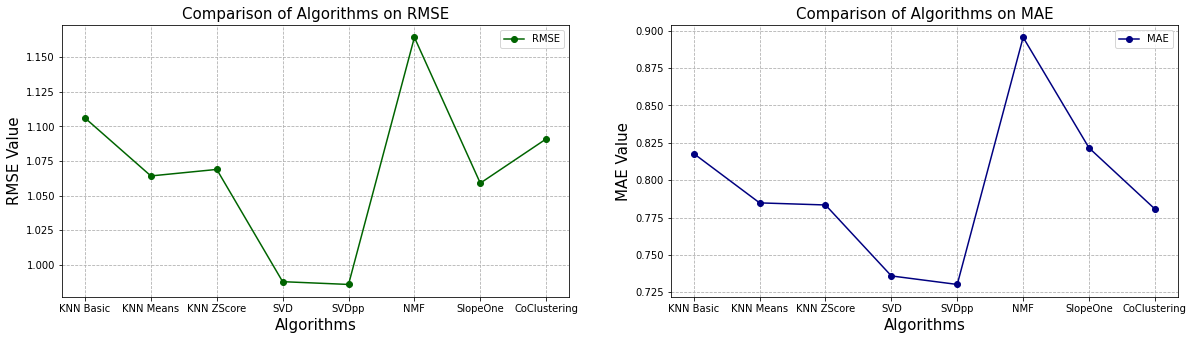

In [251]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show();

#### Evaluating Results with Cross validation results
- Winner: SVDpp/SVD (best RMSE and MAE) - very close results
- 2nd Group : KNN Means/KNN ZScore

- We have noticed SVD and KNN are better
- We will use Gridsearch for a better algo to create the final model.

### GridSearch CV on 4 algorithms - SVDpp, SVD and KNNMeans,KNNZScore

##### SVDpp & SVD

In [252]:
# Parameter space

#svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009],'reg_all': [0.01,0.02, 0.1, 0.3, 0.4, 0.6]}
#Parameters were updated after few iterationsa s it was taking very long time to execute
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007,0.009],'reg_all':[0.4]}


#svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1,refit=True)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs.fit(data)

#svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1,refit=True)
svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svd_gs.fit(data)

In [253]:
print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))

SVDpp - RMSE: 0.9855 ; MAE: 0.7403
SVD   - RMSE: 0.9853 ; MAE: 0.7399


##### SVDpp Best Parameters

In [254]:
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])

RMSE = {'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}


##### SVD Best Parameters

In [255]:
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

RMSE = {'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.4}
MAE = {'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.4}


##### KNN using GridSearchCV

In [256]:
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}

# commented out KNNBasic as results are not better than others
# also while doing multiple iterations its very time consuming
#knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
#knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs.fit(data)

In [257]:
print('KNN With Means - RMSE:', round(knnmeans_gs.best_score['rmse'], 4), '; MAE:', round(knnmeans_gs.best_score['mae'], 4))
print('KNN With ZScore   - RMSE:', round(knnz_gs.best_score['rmse'], 4), '; MAE:', round(knnz_gs.best_score['mae'], 4))

KNN With Means - RMSE: 1.0672 ; MAE: 0.7872
KNN With ZScore   - RMSE: 1.0681 ; MAE: 0.7833


##### KNNWithMeans Best Parameters

In [258]:
print('RMSE =', knnmeans_gs.best_params['rmse'])
print('MAE =', knnmeans_gs.best_params['mae'])

RMSE = {'k': 30}
MAE = {'k': 25}


##### KNNWithZScore Best Parameters

In [259]:
print('RMSE =', knnz_gs.best_params['rmse'])
print('MAE =', knnz_gs.best_params['mae'])

RMSE = {'k': 20}
MAE = {'k': 20}


In [260]:
x = [15, 20, 25, 30, 40, 50, 60]
#y1 = knnbasic_gs.cv_results['mean_test_rmse']
#y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

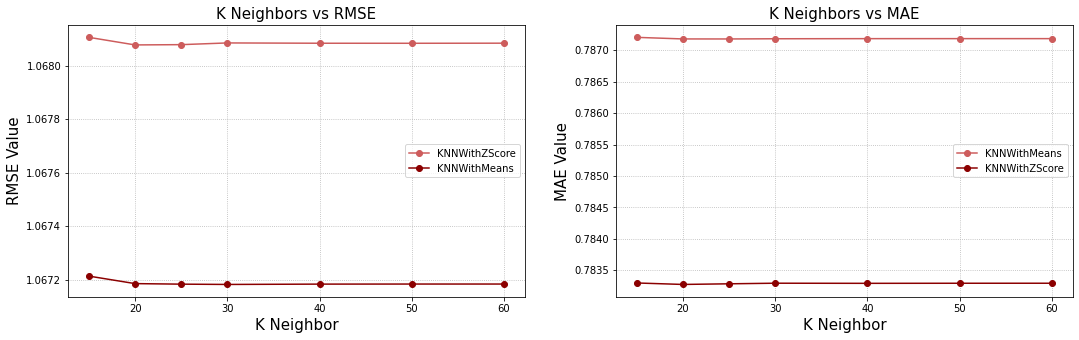

In [261]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
#plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
#plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show();

- From multiple model projection with Gridsearch we can see the best score details:

###### SVD
- SVDpp - RMSE: 0.9855 ; MAE: 0.7403
- SVD   - RMSE: 0.9853 ; MAE: 0.7399

###### KNN
- KNN With Means - RMSE: 1.0672 ; MAE: 0.7872
- KNN With ZScore   - RMSE: 1.0681 ; MAE: 0.7833


###### Model Selected
- We can notice the SVD consistently performed better after gridsearch results
- SVD++ and SVD are very close but we are plnning to go with SVD++ as its specifically designed to outcome few shortfalls of SVD.


### Final Model and Prediction

In [356]:
#For Final model we are using the identifed data set and best parameters identifed
# Set Rating Scale
reader = Reader(rating_scale=(1, 5))

#Converting and loading in Surprise format
data = Dataset.load_from_df(finalDf[['userId','productId','ratings']],reader)

In [357]:
from surprise.model_selection import train_test_split

#splitting into train and test set with 70:30 ratio
trainset, testset = train_test_split(data, test_size=.30,random_state=111)

In [358]:
testset[1]

('A3AUL23GMCOP2A', 'B003ES5ZUU', 4.0)

In [359]:


# SVD++ is created with best parameters
# {'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.4}
svdpp_updated=SVDpp(
    n_epochs= 25,
    lr_all=0.009,
    reg_all= 0.4);
svdpp_updated.fit(trainset)



In [360]:
#RMSE for new Test Set
test_pred = svdpp_updated.test(testset)
print(accuracy.rmse(test_pred, verbose=False))

1.084642354580002


In [361]:
test_pred

[Prediction(uid='A1BA72K4VK1UN1', iid='B0054CFKQI', r_ui=5.0, est=4.513206641448442, details={'was_impossible': False}),
 Prediction(uid='A3AUL23GMCOP2A', iid='B003ES5ZUU', r_ui=4.0, est=4.408203490358511, details={'was_impossible': False}),
 Prediction(uid='A5WV6BV9Y5RB8', iid='B002HZYBZ6', r_ui=5.0, est=4.740520319523074, details={'was_impossible': False}),
 Prediction(uid='A3DOCWNJH2NLA5', iid='B006ITP692', r_ui=5.0, est=4.223546179869113, details={'was_impossible': False}),
 Prediction(uid='A39M72SW9SAORS', iid='B0037255LC', r_ui=4.0, est=4.148699992213259, details={'was_impossible': False}),
 Prediction(uid='AEZ8WH06SEW6K', iid='B000067RBT', r_ui=5.0, est=4.455060128309515, details={'was_impossible': False}),
 Prediction(uid='AQ93SBYO5S7VM', iid='B00CBNAP54', r_ui=5.0, est=3.9766111590297224, details={'was_impossible': False}),
 Prediction(uid='A13BDQ7J8MNP40', iid='B003CP0EB0', r_ui=5.0, est=3.5266710127971224, details={'was_impossible': False}),
 Prediction(uid='A2VIL065SWML7X',

In [362]:
#Attempting to capture precission and recall for the test set

### Precission and Recall

In [363]:

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



predictions = test_pred
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.7487849812559523
0.6727244033421712


In [364]:
#capturing K fold precission and recall values
data = Dataset.load_from_df(finalDf[['userId','productId','ratings']],reader)
kf = KFold(n_splits=5)
algo = svdpp_updated

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.7247221147863362
0.6917063913775354


0.7245188729399082
0.6919686197041874


0.7246502313144193
0.6918024326868453


0.725649183483857
0.6915987149321751


0.7251840839478643
0.6903117950325885


### Predictions

In [365]:
testset[4]

('A23AKO4BZLZ8DE', 'B003LWXJ2A', 5.0)

In [366]:
#Prediction details for the User ID fetched from Test set
# We can notice B004LP8G0G r_ui and est values are very close by and on top recommendations

uid = 'AA6176V2HKG16'  
iid = "B004LP8G0G"
pred = pd.DataFrame(test_pred)
pred[pred['uid'] == uid][['iid', 'r_ui','est']].sort_values(by = 'est',ascending = False).head(15)

iid  r_ui       est
190927  B007WTAJTO   5.0  4.329943
206572  B000ID7QNI   5.0  4.292232
246761  B00387D1Z8   5.0  4.225566
140624  B004NBZ8DQ   3.0  4.210772
14501   B008CXTX7S   2.0  3.995037
193198  B0081EEFOO   5.0  3.819533
306886  B005S0BYQ6   5.0  3.791500
82277   B004LP8G0G   4.0  3.679545

In [367]:
# getting recommendations for all
#https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user

from collections import defaultdict
def get_top_n(predictions, n=5):
  
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [368]:
top_n = get_top_n(test_pred, n=5)

In [369]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1BA72K4VK1UN1 ['B002VPE1Q6', 'B00F0QUV12', 'B002VS4V0Y', 'B0054CFKQI']
A3AUL23GMCOP2A ['B003ES5ZUU', 'B00829THVO', 'B00834SJSK', 'B000TKHGL2', 'B00119T6NQ']
A5WV6BV9Y5RB8 ['B004SY9OVA', 'B002HZYBZ6', 'B007N9DTJK', 'B009Z3SVRM', 'B004I8NWXM']
A3DOCWNJH2NLA5 ['B009M4X7Z0', 'B007J6DYC4', 'B006ITP692', 'B007QG9Y3A', 'B007F7K6Z0']
A39M72SW9SAORS ['B00017LSPI', 'B005JZ7EV4', 'B00092GM0Q', 'B000B7670E', 'B0036SB3TA']
AEZ8WH06SEW6K ['B000067RBT', 'B000BSN4UY', 'B00DR0PDNE']
AQ93SBYO5S7VM ['B00DWV3NM6', 'B002C747XA', 'B00080G0BK', 'B006M7IDTA', 'B00CBNAP54']
A13BDQ7J8MNP40 ['B00AGAONZ2', 'B005FPT5UG', 'B00CCK1RZI', 'B003CP0EB0', 'B003922SEC']
A2VIL065SWML7X ['B003DZJQQI', 'B007BY3PNC', 'B009SAVH32', 'B006OIQFOW', 'B005HQ5D36']
A32T3LGQGWGJYE ['B005LPLPRQ', 'B00E3W15P0', 'B009NB8WR0', 'B006WAGG14', 'B002V88HFE']
A3IONEIQB9028N ['B000PY8KHQ', 'B000VSDUSA', 'B00B46XUQU']
A1AFB2VXF3G32Y ['B00006I5FQ', 'B000F8GWPO', 'B000BYZNMK', 'B000BKBYY0']
A2JG84JVWIV6BU ['B0043WJRRS', 'B000VX6XL6', 'B007BY3PBE

AT4EV7B6GHURA ['B003L4P872', 'B005CRKZOM', 'B00CF5OHZ2', 'B005DFATXA', 'B00EDIO3N0']
A3483ZGJNWRSGS ['B003XM73P2', 'B0049SCB2Y', 'B007KXI2R8', 'B00A6JFWNA', 'B005P7XSVG']
A3SDCMI9Q0XJOO ['B003ZTWYXY', 'B005CLPP84', 'B005KOZNBW', 'B009IBX7Z2']
A3EXI2ONDDLZ5O ['B0007G6RZE', 'B000U5TUWE', 'B00114LG7U', 'B000JLO31M']
A14740S445FN8E ['B001V8SOIA', 'B001F9CL4S', 'B003R74POA']
AV1QZXZER06U2 ['B003VTZE30', 'B008RJU2UO', 'B0085H65RC', 'B000CS7U1C', 'B002JPITYS']
A3FP78FX56VUK9 ['B001WB1ISO', 'B000NI9IQ6', 'B000ZLULOY']
A3BXSR4ZFZS72V ['B002V88HFE', 'B007NFIY0S', 'B007WTAJTO', 'B001AFV9CM', 'B002HWRJBM']
A2NJQF2UI60VGT ['B004J57R0I', 'B00020M1U0', 'B0012IJYZQ', 'B0055QYJIS', 'B0014TXMOC']
A2RZ321KO5TVNZ ['B00C3R14J4', 'B006QB1RPY', 'B001MBJY1M', 'B0002QLDLC']
A3UKWQS8SRW6IO ['B00ISIG690', 'B000TXZIDM', 'B005KTIX50', 'B000HRYV38', 'B00BWHILCY']
A2PAWMGNOAULRU ['B004Y02R1W', 'B005D2JE2A', 'B007YX9O94', 'B002TXJUJ8', 'B005E7TE9W']
A1ZXQH0IUQ1H7R ['B003DZJQQI', 'B009D79VH4', 'B00APCMMDG', 'B002ZIN9D

A2I0Q87CT0D3GK ['B0026JO05E', 'B000PFGQ44', 'B007LQKFG0', 'B005H16S6M']
A2IGEXRYTOS69G ['B001UALXG4', 'B001ECP666', 'B001RQ2YF0', 'B0028QWJTO', 'B0012QN3AA']
A28BX3MM90A6FI ['B00017LUOC', 'B007FGYZFI', 'B0002JY712', 'B0016KAU3U', 'B00578VBOE']
A1FOGL8ACIVFOV ['B004G606Q2', 'B001D9IGRG', 'B0018C8QKU', 'B0041OMIV0']
AVFJ327UXPXLF ['B0035FZ124', 'B005LSZ2TA', 'B0039BPG1U', 'B004Z0KPUG', 'B00JC31SGG']
A20TZLGORUSGSF ['B0042GHI8U', 'B00023JJV6', 'B000DZH9MY', 'B0064DMH5S', 'B000U07C1U']
A2L64ER55ASN5T ['B008S15WCO', 'B007RESFHM', 'B008LTB3KS', 'B006GDTTM0']
A1GND76UUE62G1 ['B002PU9U0O', 'B003SE6I7O', 'B005MLAZ8Y', 'B00B5RAJ9E', 'B003TO52A2']
A3TJGPMJLCXBUC ['B0061RJSWC', 'B002FRLEIS', 'B009VV56TY', 'B005QX7KYU', 'B008CCM3YO']
A33QVIF8IUQVJ4 ['B00761NDHI', 'B005CLMJLU', 'B003L11FUY', 'B007FC2QBW', 'B002P5YIC4']
AHHRXMMOZQ6KE ['B00104XCVO', 'B006OBGEHW', 'B00BFDHVAS']
A3CHMHGSJSQ02J ['B0052SCU8U', 'B00429N160', 'B002TOJXIA', 'B001CHHVCU', 'B007FPIP6Y']
A1GWESMII6G4JS ['B0023RRPE2', 'B00009R6W

A2WG0WBRS8AWQE ['B00CYLCN62', 'B003DKURE8', 'B0041VZN6U', 'B003UYEBE4', 'B003EGR5OQ']
A2TZW6VXQIJPJ0 ['B0016ALXFE', 'B0019CEUFE', 'B00113AYUQ', 'B001CM0IF2']
AIYAYQ0T9IXK1 ['B007H7F144', 'B003LLMFFI', 'B007P4YAPK', 'B0090EC5MS', 'B004W86GQS']
A17XZA1L9F1STB ['B00152OB4I', 'B0000DZEZB', 'B005DLDO4U', 'B008ZGKWQI', 'B0015DYMVO']
A2OY0RKXHQVD3E ['B00IVPU786', 'B000VX6XL6', 'B008G2GBN4', 'B000OZA8NA', 'B00BYKGI1A']
A2DUDFZJ0YUEE8 ['B0026ZPFCK', 'B0058M5R62', 'B001EZRJZE']
A3EROOTOOI7YCR ['B005HMKKH4', 'B002R9CQYK', 'B009W830EO', 'B005C298UY', 'B0075W8D7I']
A2X7B5F8LGHUAP ['B0098PHM7M', 'B00BN3VZDE']
A3I5S9TA5E1NT3 ['B0082PVK8Q', 'B007ISL466', 'B00D66B1ZS']
A1NHPHD9INJ9ZH ['B000DZDTKU', 'B007VL8Y2C', 'B007FEEZ00']
A2FZPRT0S0MLKT ['B007SZ0EOW', 'B0046L1PC6', 'B0084ZYHMU', 'B00CO8TBQ0', 'B001O4EPHA']
A18IUSH71LBL5V ['B0098T7CGE', 'B005CFSZE6', 'B003YNQ6DK', 'B005UWD2YY']
A3B3GXN1LV4S6U ['B0001FTVDQ', 'B004KCLIFA', 'B0002D03ZW', 'B00CBPJLFW', 'B000065BPB']
A31J3EZUAAF4OR ['B003XU6H8I', 'B003XN

A1I0V11WL18XE7 ['B009NHAEXE', 'B00407W3CW', 'B004ZNA3UA', 'B00FSAHJ24', 'B0094NXBZ0']
A3AZI828WJN1CD ['B000HGHMF8', 'B005IHAIC0', 'B007ILK234', 'B00FSA8VQ2', 'B0036V9AGU']
A15MBSPCIVB2H9 ['B000F6MOQC', 'B0002J5TGY', 'B00336G7MI', 'B0019X20R8', 'B00D6Q5H1W']
A3DSPPMYAPK4CG ['B0002YE35M', 'B00A5323NO', 'B000JI4OBO', 'B001K91RTI', 'B00005NHGP']
A1S3FOP19D8W1X ['B0007WK8LC', 'B00BOHNYU6', 'B0002Y5WZM', 'B00007E7JU', 'B004CLYJ1Y']
AOVMINQXK79DT ['B00009X3UA', 'B00913KM14', 'B004GZRE1S', 'B0056MPVZ6']
AOGNF6TXLI659 ['B001MX5YWI', 'B003BRURUW', 'B002XAPRSU', 'B003MX4D0U']
A245DTGCSY59ET ['B00AGABISW', 'B006FKPLFS', 'B00F19Q8ME', 'B001EZUQ5E', 'B004NYB67U']
A3AGWK1O5U0QK0 ['B008OEHPKM', 'B00EZPXTOU', 'B002O21XHQ', 'B000E6NGBU', 'B00834SJGW']
A2RTVGR9B1M600 ['B00006I53W', 'B004071ZXA', 'B002Y6CJJ8', 'B003Z6QH6M', 'B003OBXHPC']
ARQ4B2B1XKNCA ['B000BC8S1A', 'B001ESPB5G', 'B00008ZGSO', 'B005HGBEZ2', 'B00009KH63']
A16SSSU1OMPH7Q ['B00AJHDZSI', 'B007IMPMW4', 'B005O2XO0M', 'B001OAR26K', 'B00IZ5B4M0']

AQGYNBNHRQYEN ['B004XO8DMG', 'B0002J2EPI', 'B00009R6AV', 'B0068LACAI', 'B00009V38M']
A1WORRNIQWGAZ8 ['B000OFTRKU', 'B002VPE1WK', 'B0096T2N3I']
A2OQH4OGA3VME1 ['B001TH7GSW', 'B0040JHVC2', 'B0041MY32Y', 'B004FQX0NO', 'B003QA0MWW']
A25DQP2LCQI62X ['B0055YB5IC', 'B00A7B0YZI', 'B0049OJNRE', 'B004I6MAXW']
A1MUV2ZNDGQP9V ['B0084G3FKE', 'B00F4A8FQM', 'B000PNGM18', 'B000063YAR', 'B009LL9VDG']
A2NPQM672LHELI ['B00EHD8J3Q', 'B003ES5ZUU', 'B000SOQ6KQ', 'B000T8SO4M', 'B0007WW5YK']
ANDL04QI2BLD8 ['B004NE4OKQ', 'B005K8AUE8', 'B00BAH7LI6', 'B004VBEI0M', 'B006VPJQFS']
AQ9Y9A6Q9UELW ['B000B9O83A', 'B002C9RGV8', 'B0041OSQ9I']
A2YG5GKMAMTIGZ ['B0007WK8LC', 'B000U9WVW6', 'B000WCU0Y2']
A1BM45N5F304KL ['B000EVLS4C', 'B000EXS1BS']
A2ZNOGRFD8UXV9 ['B00BI9X7UC', 'B00004ZCJE', 'B00CXXPUZ2']
A2C4LTHQRBQNO8 ['B004VS2ZRS', 'B007IG2YLW', 'B0045OFBJC', 'B000NOECMA', 'B0018S1LZQ']
A1JI5H6EO1DDMX ['B0007A1IRC', 'B002QEBMAK', 'B001PCQTDO', 'B002HOPUPC']
A379DLIAF0MFM5 ['B00BOHNYU6', 'B001TH7GSW', 'B00GBATPFO', 'B00AQUO5

AB0UTF1HTQLXC ['B00AJBIXK4', 'B005C8QVEY', 'B0009VU7TO', 'B001RVGTM4']
A226YW0T8I0EZA ['B001S2PPT0', 'B0036AWR8E', 'B003BQ1D4C', 'B007G5NNOW', 'B005N8A4Z0']
A4UHHOLH4OYQK ['B000UIA6YM', 'B007EHI1DK', 'B0039S00KA', 'B000BI6AH8', 'B008BUGQKY']
A1RJMEVTRP7EB ['B00IDUQRP6', 'B002KETE24', 'B0042X9LC4', 'B003ELVLKU', 'B005FDWE4C']
A30VBNKEJGIGFW ['B0002E5P1I', 'B003FMUL5Y']
A3FZ0J725GFE08 ['B006OBGEHW', 'B00IIHNVF8', 'B00FUU3HRI', 'B005KDGVK0']
A2RWHTNM5P3I8Y ['B00005LB8P', 'B004QOAF7O', 'B00EVIBN8U', 'B005EJH6Z4', 'B004RMSMKM']
A36YVHFOZOXWL1 ['B001P751O2', 'B003S894R6', 'B001N0W2YS']
A34BJBD6WQBH9Z ['B004S4R5CK', 'B0032G618O', 'B002ODG5GO', 'B003OTXBY6']
A2UCXHVVN5L005 ['B000Q8UAWY', 'B001N4NLO4', 'B003CYKYVG']
AGEWOMQ90BV8R ['B003A4H2J0', 'B000068O5H', 'B002OEBNJC', 'B004NY9UUK', 'B001T9N120']
A2MD6815TK32I4 ['B0015A8Y5M', 'B002RCNX8K', 'B000OG4E2U', 'B002QAUN2M']
A1XWJ0NABYC1MA ['B0023RT0QI', 'B001Q3MA80', 'B000TB0RY4']
AEBC5HHLPWMLC ['B005GI18EI', 'B0046ZGUNG', 'B00000J1V5', 'B000UTQOEW

A26QSJ1HE5XCJF ['B005KWHJES', 'B0061RJSWC', 'B000CRFOMK', 'B00006HWHK', 'B004Z94BA2']
A29FXD4BM20WWY ['B00005LE76', 'B00064V6SK', 'B000R7X80U', 'B003VWY0VY', 'B00007EDZG']
A2NG1RE7UX6ST0 ['B002HU27UW', 'B004DKVRDM', 'B00A9A6MAI']
A26SCZK48U4FXC ['B0090A8TWW', 'B003RIPMZU', 'B00200K0VW', 'B00009KH63', 'B002J46IYW']
AGL0YCXDMAH4U ['B0028DRABE', 'B000BFWJM6', 'B000GU88CQ', 'B000F6OJOC', 'B0001XU8BW']
A20GZFBHU4Y3NB ['B00DILMFNS', 'B0007RXDDM', 'B0095VPAVE', 'B0002BBQMI', 'B00009KH63']
AIFIR7HW14ONC ['B00366PSC0', 'B003SQ1JTY', 'B0036QF0BE', 'B006LFL4X0', 'B006ZBWV0K']
AAAPSX40UNNRQ ['B001E1Y5O6', 'B002E6R7NG', 'B0047ZH0B6', 'B0021AES4G']
A33LJOB2M50S2M ['B007R3Z44U', 'B005TX3PGE']
A36EWFSZD2Z6X5 ['B0019EKHEU', 'B000K2NVEU']
A3S8SYIF5AMGQ2 ['B000VDF5RO', 'B001PNJM8C']
A38RMU1Y5TDP9 ['B002IORQ6W', 'B0050IE1O8', 'B00HFW1E6K', 'B0027G1ZF4', 'B001AAN4PW']
A1UJRRKIR21R0M ['B000XRXCCS', 'B001R3M7XM', 'B00112BKT6', 'B0061GQ7PO']
A3U1WPDQLP9CQ ['B003ICXCCK', 'B004IM4OJ4', 'B000MGNDHE', 'B005LIDMYM

A1BC62X6HZJGZR ['B002IL8XRQ', 'B003ES5ZUU', 'B005LJQNQU', 'B005FN5DJA', 'B00BQ4F9ZA']
A2ST0LCR4KSXSV ['B0050JS1QG', 'B003UT6C9G']
A2M4K8AQKBLYQO ['B00007E7C8', 'B00427TAIK', 'B00ATM1M92']
AMA2MRO8YGGHJ ['B008D2IHES', 'B000067RT6', 'B008KF7H8U', 'B002MUYOLW', 'B0045371FU']
A24Q02CT98489C ['B001NJ0WCS', 'B007USMJ3Q', 'B004M5H660', 'B003L7X44S', 'B008MWBY6W']
A28I19Q54MYXGV ['B0034XRDU0', 'B004IBK3PE', 'B00FJWKYYG', 'B00B7MZEW4', 'B000AOKTJ8']
AXPPWAIY5K9V8 ['B005PQTYHE', 'B0041D81WQ', 'B00AXLVQA4', 'B0031RGGFM']
A2T3S3VTW65VO5 ['B00C3R14J4', 'B001TH7GUU', 'B00212NO6W', 'B001Q9ERAS', 'B003UVCSZ6']
A2SOLMON5ZNC84 ['B000QB917Q', 'B001YHUX2I', 'B008HK50ZA', 'B0006OCZGW', 'B002HU27UW']
A1FXPPBA81AHNI ['B003EEMFUC', 'B005N0K4WQ', 'B001B1RLFE', 'B001E4E53Y', 'B0012OGF6Q']
A2AVX8HN2XX0WQ ['B002RCNX8K', 'B000Z80ICM', 'B00280KIJ8', 'B00DGH08OC', 'B0098Y77U0']
A47A738J85CSV ['B000F9YN22', 'B001NLV4TQ', 'B004AJ8HIE', 'B005AIJ6J8', 'B003E2TSKO']
A11GAD7CMO5Y1B ['B004RE3CFU', 'B004GZRE1S', 'B005IQRMN4

A2MJ83CD64LWEX ['B00506QPDU', 'B008UY5WL0']
A1PF6BKW386KM ['B0000AG92Z', 'B00BXA7N6A', 'B00E3JE5UK', 'B005FDWE4C', 'B000GASM4K']
AJRT00FE1X9XA ['B000M5U9GI', 'B001CIREXA']
A180GT4JL6MXKV ['B002IV6OHC', 'B002W3IXZW']
A153ANI1XP1J4Y ['B00746YHV6', 'B001L4A76G', 'B00AVYPN5C']
A2WRH5A5KYR938 ['B0041F0JA6', 'B007UYKG4E', 'B003XN24GY', 'B007OWPNVI']
A3BAOIC7JMCY6R ['B00829THEG', 'B00JC5Y6WM', 'B00F36Y9XU', 'B00EOE4G4E', 'B007PG02Q4']
AOP5SQ898AX2D ['B0055FS1V0', 'B000VX6XL6', 'B003C2T03G', 'B001T9CTRS', 'B002FB7IWU']
A3SQ7451HO86TE ['B006WVVA28', 'B00EM2JQ8E', 'B00BP5N3BM', 'B00AQBBD9A', 'B00275C2L6']
ALUGQK5ZP5HIL ['B003X26PMO', 'B000SEQGT2']
A331IK9CXHQVUN ['B002SQKL7Q', 'B00A4ZXE40', 'B0041Q38NU', 'B00A7VYO90', 'B000GUTMPI']
A2FNA5903D9E6Y ['B00HO5JE3I', 'B006LZNP3M', 'B008ULPE70', 'B006WHPQUO', 'B0097CXWUW']
A1VJ0V58N0698J ['B004YLCN1U', 'B007M50PTM', 'B000VRYG3O', 'B004TB70Y0', 'B004VM0SE6']
A3QLAOOTFEHCJI ['B0045ZEU52', 'B000S95AY4', 'B0006DPONE', 'B0042A8CW2', 'B00DVQFECE']
A32C3DE7AP

A2U7PFF129V8G7 ['B00GL743B8', 'B00GN5K63M']
AAFG4FC0KY26C ['B002JPITXY', 'B0011B9F1M', 'B007R00TKM', 'B008RK9XTO']
A22K9LJL278AF1 ['B0002L5R78', 'B000PH77A4', 'B0096TTOHG', 'B007Q2HCNS', 'B0089KJPM2']
A211QYKZXHBY2K ['B0006GCCWW', 'B001XUQOHE', 'B0009X1U3O', 'B00BGGDVOO', 'B0089ZV1WY']
AW6SPEC5AQAW9 ['B004265YU4', 'B000HP3IS4', 'B004VC3NM0']
A2HYGVFW1KL84C ['B008UHK3KM', 'B005AF0C2G', 'B004V68IQ2', 'B004TPZSTA']
A305YZ79VZR02F ['B002NEGTSI', 'B003F69JBW', 'B009UHO1L8']
AMB2Z4FMDBWQY ['B00HQECH54', 'B0000659UG', 'B00CCIKJDG', 'B008X1BV2Y', 'B005FPT56K']
A17U3VXV339Q5O ['B000UMC394', 'B001KB6Z2U', 'B00084O8A6', 'B002RL9WDQ', 'B001HQFJYI']
A2LEVJAOI6RJAQ ['B003I7UE5I', 'B003SQ1JTY', 'B008ZGKWQI', 'B000HWZIL2', 'B0088K7QUQ']
A1C2GE8A5VCTW1 ['B00081NX5U', 'B0002IWC9C', 'B000CM2Y1E', 'B0006I09OS', 'B0011EA9GE']
A3AK6FOLSB27TW ['B00125Y0NU', 'B00005T3G0', 'B002GU5XKO', 'B004XJ7LGU', 'B0075SUHKI']
AILAUL7EL5VSX ['B008CBQSKU', 'B00EF1OGOG', 'B008TSVZHM', 'B0077V88YU']
A2ZU3PK0M5JMDM ['B005G88RC

A2U9SB89TPKTI5 ['B004YDUZ22', 'B0043T7FXE', 'B00173M18S', 'B003ELYQGG', 'B004J2HTPE']
A25E612NQBSINM ['B001S2PPT0', 'B00017LSPI', 'B003TM600U', 'B0079M711S', 'B00A3DLG7A']
A1ALO747RKR4J7 ['B007JBN6AO', 'B009WU5XUG', 'B009LVPYDM', 'B004W4YREK']
A2V52AKIJJQG7W ['B003M6AGWG', 'B0035LD0EY', 'B00470XF9M', 'B001FOPW3U', 'B0023X9YCM']
A2OXHCV8W4WO64 ['B003VAHYTG', 'B006U1YUZE', 'B002IT1DNO']
A2XP7WNBX8UJMM ['B004G8HXXO', 'B008OVGRP4', 'B004V6BQ3O']
AVRONIYLZDKYN ['B0002EQU6C', 'B006OBGEHW', 'B005DU2Z0A', 'B005QFH8JK', 'B0014KQ4PA']
A3GKOWG6UIIEKX ['B001EBY9HO', 'B000F3NL5S', 'B007FH1LJU', 'B000LQMKDS', 'B00IQCRTXU']
AZMEWIXITVZF8 ['B004GZRE1S', 'B00004ZCJE', 'B002YF6ADU', 'B0036D1SGS', 'B000H0338Y']
A1L8W58BHXTF7I ['B003BROICK', 'B003IPC5FW', 'B002Z58GQI', 'B0049514SO', 'B000CQPWMS']
A3LNINIE7WQVGY ['B0011ZK6PC', 'B001N0H8YW', 'B000C21JSS', 'B000MW7B0I', 'B000RYS3S0']
AY0EQOAO9TQDP ['B00B9BUZW2', 'B001WM73P0', 'B004ZEZGE2', 'B006P88VSE']
A3E9857YP2TYEN ['B00158QASW', 'B00ATM1MVA', 'B00EE1ZH6I

AZ8XSDMIX04VJ ['B000LRMS66', 'B002Y6CJJ8', 'B0009GZSSO', 'B00065ANYC', 'B001QWOXZO']
AW9936UP187T7 ['B008OHNZI0', 'B001XURP7W', 'B007JD4T4E', 'B00BUL4NLU']
ASQ5357GTL3PV ['B008LTBITY', 'B002U2X59O', 'B002GQPSZI', 'B005DSPLDA', 'B00B3Y4FAS']
AZ7N0TLPDP156 ['B003FVJYF8', 'B000FNFSPY', 'B000UIA6YM', 'B007WTAJTO', 'B000065BPB']
A1XXMNLOLKNO0I ['B004YWIJSA', 'B0000BZL1P', 'B001KBZ3PK', 'B0000DK3I4', 'B0088VQEV2']
A3GO01HQ00B6J ['B007FTEO1A', 'B00BLZDY6A', 'B0062HIQLU', 'B00BW0X6EE', 'B00DR0PDNE']
A15267DALVDIWL ['B001RCD2DW', 'B00GP4BVTO', 'B00AQC9FHG', 'B007AHVOQ0']
A2GZ9447YUAP7G ['B002S5NJOE', 'B009NHWVIA', 'B0051YS85O', 'B000UD3NTC', 'B0050AMJXG']
AWHJLUPKZO2QD ['B007WTAJTO', 'B00A2XYH2W', 'B000I20AJ6', 'B00E19AX4O', 'B004OBZ2Z4']
AL1ITWCH7W86I ['B0009HTB0Y', 'B00004Z5M1', 'B003ES5ZUU', 'B000P1R9QM', 'B004QK5N5W']
A39X0TAGETRBFK ['B00724VC8G', 'B00CMMG7I8', 'B003Y6NP72', 'B003FSTBQS']
A34GB2ZA1JLGND ['B00FGOTBQO', 'B008I640HW', 'B000NMFCIA', 'B0002L5R78', 'B00B7GV802']
A3CNZRSY56E9HC ['

A26XDUB031X5AV ['B004HXDVJS', 'B003NREDC8', 'B004M8ST5Y', 'B00547FV30', 'B000O9W74E']
A3U6SEJ8TQNSY7 ['B001JT346I', 'B0033TJPJW']
A2YND5M9WCFXID ['B00608XLUM', 'B00I2VIR2M', 'B00AAIPT76', 'B0049XGNKK', 'B00EURB8KK']
A1DXE6GODEAXS2 ['B008EQYRRY', 'B009UEAZ84', 'B00B7GV802', 'B004GGUASG', 'B0006BGV2Y']
A2UYNRUAY69W0W ['B00CI3BISU', 'B000ODN7VM', 'B0095P2F1S', 'B00092M1SS', 'B00CPZL9C6']
A2WQPBT1JGLAMV ['B00DC8IEE6', 'B000067RBT', 'B001413EQ6', 'B008PBTPN4', 'B007Z7ZJ66']
A3P3XP70BMBX06 ['B004YDUZ22', 'B000JE7GPY', 'B00D78Q2DQ', 'B009B8EBZC', 'B0013LRLUM']
AGBFIQMV9L61Y ['B004MMEHH4', 'B003YCOL4W', 'B003LPUWT0', 'B00AXVXXNC', 'B005VAORJO']
A134HFABW6BMZL ['B005S8ND9O', 'B001F6EIY2', 'B005EJH6Z4', 'B0042RTQPC', 'B0046RE00Y']
AWEOAL4GLI498 ['B006FKR1PG', 'B007EUO2F8', 'B00013M6NU', 'B002H0DUBC', 'B001TP6TDW']
A3KXN3XJ8CCLGK ['B002K315C2', 'B004W446B4', 'B002MG6OO6', 'B005CMHPPO', 'B007EA48MA']
A1274YSRIK3JQY ['B007UYKG4E', 'B00AQDSWSS', 'B003M4KSC6']
A7UHROFQ35I37 ['B009W8FVCI', 'B0073W281W

A1J0WRGC64Z5TW ['B00I4ST9DE', 'B008PRPKIC', 'B009UEV9T8']
AMX4W9R644POJ ['B008FJWETS', 'B004M8ST36']
A1T9A8YD2FU9UF ['B002YNY8GI', 'B008MB71IS', 'B002IKLJVE', 'B000OW5TPA', 'B002DP1FTU']
A16ST45VPZFKQ7 ['B007RHT3VG', 'B004353JBA', 'B009HVIW0I', 'B004WAUX4W', 'B0061R1XI4']
A1UX6GTMKEH98J ['B00FZ9SJLS', 'B00IVPU59W', 'B00829THEG', 'B0052ROEJE', 'B00DQZQPNM']
A1JBKSNL6IO7DH ['B0073FE1F0', 'B004CO9AFQ', 'B00EAR8S76', 'B000VPC44O', 'B001D9IWIY']
A2H3F5QEUOED39 ['B00376ILO6', 'B003Y8DIRC', 'B007FXQQZS', 'B00829TQ6A', 'B004G8QO5C']
AGIVHD7LPSXTN ['B002V88HFE', 'B00APCMMDG', 'B003QWYX8E', 'B005S2FNC0', 'B0000AHO92']
A3C00N4UHA5XYX ['B0035ERKYW', 'B006L15TZS', 'B0063705PE', 'B001TK3R1O', 'B004QSTWVA']
A2CW9GKMNFAU6R ['B005484N9W', 'B0006TU54G', 'B0031X8HG2', 'B0036RFGKS', 'B001U5NWQ8']
A38IJCQMF91VFR ['B000P61E36', 'B000VOC90Y', 'B0002KR88A', 'B001S4OTS6', 'B0002ZPUMG']
ABY0DJN2V7T4B ['B003ZSP0WW', 'B007MV8UMA', 'B005HSG3TC', 'B003IN40NE', 'B005QFH86S']
A2YBAHB747219P ['B000I68BD4', 'B000078CQS

AX1M4U63MFJDH ['B0019EHU8G', 'B0009YJXMS', 'B007P4VOWC']
A36LO6ZA8EUEHM ['B00B588HY2', 'B0042BBLP6', 'B000IF51UQ', 'B002VR6A9K', 'B004KPGPXW']
ANQ0Y8GK9K73K ['B005CWJB5G', 'B008KE5EOA', 'B002MAPSQM', 'B001MBLBXQ', 'B007471PZQ']
A1FKJV7U7IXE1L ['B004PW04B4', 'B003ELYQGG', 'B004300OEK', 'B008279OJ6', 'B0007GIXQK']
ATLYYBE1OCCTO ['B00IT1WJZQ', 'B00322ON1K']
A3UFYYXJP6KSFR ['B002SRQ214', 'B0064R9H2A']
A31UZ5J1ZGKDDJ ['B005J31BCO', 'B00009R6FV', 'B00IT1WJZQ', 'B00D76RNLS', 'B0049PQTLQ']
A2IDZP6NK9MBOS ['B001LQSFKY', 'B009EADB2Q', 'B001716LMM', 'B000EI0EB8', 'B000V4OSMQ']
A2YTX7UQDSWLKS ['B0001W7TXI', 'B0007KX4VU', 'B00093IIRA']
A1RMF40TB1XLQ0 ['B003L137Y6', 'B0094PI0GI', 'B0042YUAR8']
AYS4UGU2YB0W4 ['B001AALJ2M', 'B00COEBCXY', 'B00FS6O24Q', 'B004CLYEDC', 'B007X3VC7W']
A270ZMTYUAO1HB ['B0049PQTLQ', 'B00026BXQ2', 'B005H3AU1Y']
APPEHP9XMWRNI ['B000I1ZWRC', 'B00009R6QP', 'B000UC3CN0', 'B0001Y7PSK', 'B0044XU4IM']
A3UA33CYG5JO0O ['B008CNXXM4', 'B002SQKL7Q', 'B0042F3K9W', 'B00BQO56Z8', 'B00AHDXU0W

A3E36KSFDU6MY6 ['B002V8C3W2', 'B001QUA6RA', 'B000EB3S4A', 'B0039RSXUU', 'B002LU80QS']
A2TAY3SZ3TF5EI ['B0045JNBNU', 'B002J9HBIO', 'B005FO0M9A', 'B005ONMDYE', 'B006Z95LHW']
A21WOESZQ6QEU4 ['B007X8LGV4', 'B00006HYJ3', 'B008VGN75U', 'B003E2VHMQ', 'B009GISUL8']
A1DF5D8N00SQR0 ['B007K48EM0', 'B00AULINY4', 'B006OT3AVW', '9625993428', 'B004P8E612']
A33ZPYQP2HN17H ['B003E1IQ4Y', 'B006BU4TQY', 'B004MEZ74Y']
A2B7VX6R4YVCXM ['B005HGG3NK', 'B00F03P4RQ', 'B00EL93M3S', 'B002SZH2OC', 'B005USRBVI']
A2Z5IUIPKV3G4M ['B004CG11SS', 'B00104XCVO', 'B002RM08RE', 'B0071NWYP8']
A2TS471DAEZTJU ['B004M8SBC0', 'B003O5MTYS', 'B0062P7ISY']
ACCR7OYHT2OXE ['B00336EM0W', 'B00AR299XK', 'B0055I183U', 'B007TMZ1MY']
AJLPO65C2V9NG ['B00D5Q75RC', 'B000ERAOMS', 'B001FA1O18', 'B000JF79PA']
A28H0PJ476S1BQ ['B002VPDOH8', 'B001PNEB5G', 'B00009R6TA', 'B0002ZLYYY']
A101OAAMZYWQ3U ['B000BJKFIM', 'B0002UBDMM', 'B00011CS0I', 'B00002EQBV', 'B0000632GL']
A3MBTVX9FJQU2S ['B000QUUFRW', 'B001CIREXA', 'B0062W02C6', 'B009STMN9K', 'B001TSMJD

A2G799IEK5UMP7 ['B002G2BTTQ', 'B00937CTQO', 'B001D72NE0']
A27CEMG5JZO95F ['B003L1AGVS', 'B001TH7GSW', 'B001BZENZQ', 'B00908BMVE', 'B004SBBD8U']
A3BB2RC775TBZ1 ['B00G97AJMW', 'B0002RBQO0', 'B004Z4FBE2', 'B000P6R3DQ', 'B001MX41VS']
AEQG4TJGGZWRE ['B0058UUR6E', 'B004K3IHMG', 'B0057FRTPW', 'B007NMPA9Y']
A25MLH76YYX61R ['B000OG6I6A', 'B0017QFHR2', 'B0000E6S0Y', 'B0007N55NW']
A38QYNSFHCBTM2 ['B0052SCU8U', 'B005GI18EI', 'B00558O31Y']
AIUWBR79VSZ8J ['B0099SMFP2', 'B003UI62AG', 'B00DWMPM92', 'B000UY3NR8', 'B008FKRSMK']
A13S5BQ0VY2LTT ['B0077CR5RK', 'B001NPDA44', 'B007PXV30G', 'B005K2Z99U', 'B000WN00FK']
A1HYDE16Z8XNK3 ['B000BM8RFM', 'B000NWG3RO', 'B00DCKROBI', 'B000Q9UFKU', 'B0037BHZLQ']
AW8ESDU0C82O0 ['B0012KZNP4', 'B007IV7KRU', 'B0032FOJP2', 'B0027VT6V4', 'B00CP7R270']
APQQDSTMZZN3T ['B0039JBXVY', 'B00AJHDZSI', 'B00005V8R8', 'B004VM1T5S', 'B0078PY0E2']
A1H1GZJ0UIV21Z ['B0031QNP8O', 'B000ACGQI8']
A3U3PXRAYLZMKK ['B002JIEPNY', 'B0032FOKXS', 'B009GJXO9U', 'B00009W3E2']
A1RTAHBXOPLCSI ['B00BJ1COY

A2RKDHBC8VGY0K ['B005LTJ4O8', 'B000067RKF', 'B001LYSVE6']
A2D8OM8XL872DO ['B004W9BKE0', 'B0049XR5MK', 'B0099TX7O4', 'B003LPTAYI', 'B0000A2U5R']
A3P07C1HLOWDYP ['B001542X5K', 'B004Q1P0S6', 'B0006U6GH0']
A2BVCAJW140CG4 ['B00GTGETFG', 'B002A8IDQI', 'B00FK0ELM8', 'B004JKNFQ8', 'B0040JHI4S']
A1C4B7FWID8INF ['B0009NCFRO', 'B004BFZHO4', 'B001V5J4KA']
A3REUILBAGPS06 ['B000NDA5E0']
ASKPL1EEJT81W ['B001413D94', 'B002IKLJVE', 'B005AIR2TE', 'B005J5TZVG']
APSV02SOZ0LNY ['B000BP8AY2', 'B0009HN57Y', 'B0018Z2Q2G', 'B000P6J67C', 'B000IBNXX2']
A8EJA4AMJNO6C ['B0002L5R78', 'B0068INSUM', 'B004RJJMBI', 'B009H8JOZS']
A11PS8LVADMK2Q ['B004W2JKWG', 'B004UE1Q7S', 'B001NJ0D0Y', 'B004TM1JBE', 'B005K5I9QW']
A4G4MU9DUP834 ['B005BKMHKU', 'B0000DD7OH', 'B004M8SVBG']
A1R2N0T84UUF7F ['B00007FHDP', 'B000095JBE', 'B000X3FAJU']
AUQ4YLHHS478X ['B008BDBPT8', 'B004W2BAXI', 'B003L18Z34', 'B00CO07C6E', 'B00006I53A']
A1HH29FVSTXJVA ['B000VX6XL6', 'B001XURP7W', 'B002QEBMAK']
A3VRRU3RA6PPX4 ['B007IV7KRU', 'B003UT2E8E', 'B008THTR

AUG0C084W05KI ['B0002GRUJ6', 'B00BSEZ4Q2', 'B00DBX371C', 'B00064V6RG', 'B000R1ZK16']
A2ZWNR1KFP1CT ['B001TH7GUU', 'B006C6J0V6', 'B000CRVDR0', 'B0011FOOI2', 'B0009DT87O']
A2VOZX7YBT0D6D ['B000F2HGWI', 'B000M4KXK6', 'B002HHLOWC', 'B000095SB6', 'B003K1VABO']
A1AQ9GAOB2J1H2 ['B0012Q9976', 'B008VRVUFS', 'B004HC5IPE']
A2XL01KYKF0VLE ['B0078IWPLE', 'B0019M4FZE', 'B008AFZ0TS']
A1O3AM1W8HSG7V ['B000URBQSS', 'B00083B8N2', 'B000TKHGL2', 'B0036WS4D4', 'B000PCEFXQ']
A3TG6A1TIT7CM3 ['B004X2TJ1W', 'B003ZUIHY8', 'B00AF3DM8E', 'B002TMRZOQ', 'B0096T97OG']
A3E9O1VNJ3U324 ['B004EAHJAG', 'B007PQ0K1G', 'B001EPVOQY', 'B007ZLN00E', 'B004GMAAJY']
AUT9HSLT32RGJ ['B0002JUH4I', 'B0002Y22VE', 'B0000C8VEK', 'B0000510T7', 'B00006D2L7']
A16YMCFWGSFGS9 ['B003VX56MK', 'B008GVNP2K', 'B00CD8ADKO', 'B00AAHT8JC', 'B00AR95FOU']
A1G2PJDZG31P79 ['B002V88HFE', 'B007WTAJTO', 'B00AYQ433U', 'B000OTF6G0', 'B004I5BUSO']
AFR82BF45HYSU ['B0019EHU8G', 'B000JC5DAG', 'B001AO2274', 'B00358P4OQ', 'B001UGNKQE']
APDTWLZZVJON2 ['B00894YP00',

A1ZZ85SS43PCDJ ['B00BXF7I8I', 'B00EZPXTOU', 'B00752QXZ2', 'B00BBNLGFI', 'B006GLEZ8U']
A1LXUP5RDALU5D ['B00555QYS2', 'B002UFYX10', 'B003RLJVYK', 'B00358IMTA']
AUNN3E6VGZNM3 ['B00006I5GO', 'B007Q7EG7I', 'B000RZQZM0', 'B003BEDQRG', 'B000WJOF1O']
A2DLY1BLDQRWGX ['B002Y32Z2C', 'B000WPDKRI', 'B006345EQM', 'B004COIBFG', 'B0070Z7ITE']
A4FNK6YFV5OCC ['B00724W0N2', 'B00AN5PUSE', 'B009SYZ8OC', 'B0000AZK4G']
A3PKBEQ8A9NATT ['B004C4SHQY', 'B009DCNP9O', 'B00F5NB7MW', 'B00BO2OU90', 'B00EB82KUK']
A2XYH5U7IG60X9 ['B0029LHVLO', 'B001F51G16', 'B004357WL8']
A1LI033VZ85RH1 ['B00GTGETFG', 'B005FYNSPK', 'B007C1KOEW', 'B00HY3032G', 'B00006HYKM']
A3KUT0KMWU9IGO ['B000BUK7KW', 'B0003NN83K', 'B000UN752I', 'B000OCRKP2', 'B0009RKL5S']
AHFWJDTF4V5SK ['B002Y6CJJ8', 'B002OGMNT4', 'B0037SNTJQ', 'B002VR6A9K', 'B0036PFD80']
A3D1TZH619NKHN ['B006LW0W5Y', 'B002TLSOG0', 'B00829THVO', 'B0093HMKVI', 'B004HW7KAU']
A3JSM19WZS65J1 ['B000H175AK', 'B000OX0OG8']
A3IMK08UX0I46A ['B004CLYECS', 'B009FUF6DM', 'B003ELVLKU', 'B001R8XOE8

A3345MYPQLZYJX ['B0087G7IMM', 'B004W2JKWG', 'B0066130CM', 'B0058J1QYC', 'B004LWYE4Q']
AT6EUQERXGR8Z ['B000VDLA5A', 'B0013CHSVI', 'B003SQ44AA', 'B00CMEN95U', 'B000JSSY74']
A31I9ZUOL6GCFZ ['B001DFTGR4', 'B000OUZC5O']
A29OW5Q8ILG5L9 ['B00A2BWAY6', 'B005LFT3GG', 'B000SE6IV8']
A273Q11KTTEB7T ['B0027VT6V4', 'B000W9DJ1Q']
A32Z1TDULHZNVK ['B001O9X9EU', 'B006ZBYHB6', 'B00019068G']
A7C8W60CRXOC9 ['B004ZEZBEC', 'B000HZ9CCA', 'B00291XP46', 'B003960F7K', 'B000VM8EDW']
A3QJGC6TBUW6BB ['B005HMO6A6', 'B001F42MKG', 'B001DJ9GOS', 'B009QUDLC4']
A3DQMCSDVDC2TN ['B0037QF9UA', 'B00134LUE2', 'B005FW56WA', 'B000063V09', 'B00D7GH7O6']
AQBAN131RIXIZ ['B00000JDF5', 'B000067RBT', 'B0012H6H7A', 'B009F29ROY', 'B000VIQ6AO']
ADOXOMO6IV84I ['B007NZGPAY', 'B004Z0S7JW', 'B004PW04B4', 'B007YXB55U', 'B00026BQJ6']
AMXOES34C90K0 ['B002NVC1DS', 'B00080G0BK', 'B008KYH8TY', 'B000IJV4BC']
A1ELPH9PLO3ZUK ['B000CKVOOY', 'B004TGR8CE', 'B003T0EYVE', 'B002FGTWOC', 'B00436G2OU']
A3OEGVSXY0Y07W ['B00004TDLD', 'B007UQMOXI', 'B008YCYZXO

A1GXZ4MIB8RWGS ['B001EPVOQY', 'B003ZI1882', 'B007NOI198', 'B0015E4CFY', 'B00392CI7E']
A31R5Q7VRMSXNS ['B005ES0YYA', 'B002WR7VSS', 'B001S2RCWI']
AGP5OR29WW9QZ ['B0012GK3MQ', 'B0007LXRC0', 'B004D1OBFW', 'B002LITT3S', 'B00009W5QS']
A225NJHTDAKEGZ ['B001QVLD8A', 'B009SYZ8OC', 'B0026P34IW', 'B0002GWXLQ']
A1QT5R11TBWJ4K ['B004VM1T5S', 'B000P0PF9G', 'B008HY8XTG', 'B002QEBMAK', 'B008UHK3KM']
AI8ZHTJ1JX1R3 ['B00821BLX4', 'B008OHRJ32', 'B00E3RH5W2', 'B0054ZLLBS', 'B008OR5QKU']
A3NK89SEOVQFCQ ['B0002J5TGY', 'B0028Z3T6W', 'B00004ZCJE', 'B00622UTWO', 'B004CGHDEO']
A31GWV4EVDW6H6 ['B0019H7S44', 'B009WSCW4S', 'B004SUO2ZM']
A2JFEGDVGO239R ['B001L1H0SC', 'B00123WZWK', 'B002YXS8E6', 'B004AW6RUQ', 'B000V0ETA6']
A1EDF2C11DNI7X ['B00E3W15P0', 'B0002BEYS6', 'B009NH0MPE', 'B005RFOJT6']
AEOGY1NQ55BX0 ['B002BH3Z8E', 'B00A9YQP8I', 'B0081Y0Y4E', 'B007NG3WR2']
A141R97FHSSUQ0 ['B005FDXF2C', 'B003XDU2Y0', 'B00AJHDZSI', 'B005JW6WQU', 'B0054L8MR8']
A5IALBY2QXSS ['B003CVLTCW', 'B006ZH0LW4', 'B0011NVMO8', 'B00DJ3DWFK',

A203WLJ31GIUTB ['B002P5VKSE', 'B002V88HFE', 'B005DSPLDA', 'B00IUF7VKE', 'B00JF0D7RE']
A3M17XG8HL7JRF ['B0054L8N7M', 'B00685ZCZY', 'B0050SPZMK', 'B003HKRVAW', 'B00689F764']
ATIGZKAH30KEW ['B0002BEVXY', 'B002WGAHYY', 'B004AFCVDA']
A31963LAQG70TO ['B00018MSNI', 'B0090Z3QG6', 'B0078Q4FEG', 'B00BX04Z48', 'B003JQLPYC']
A31GDWUM6AGI7S ['B0083BWGDC', 'B000JNQSIQ', 'B003M0NURK', 'B004GZRE1S', 'B003OC6LWM']
A1BVN8OVG91D0H ['B004XC6GJ0', 'B004V3NOT6', 'B000QD7BT4', 'B005FXYJZY', 'B000051299']
A1BPPZINVQ2CE6 ['B00834SIO0', 'B009LRR5AQ', 'B000067SOL', 'B004TA8YNW', 'B0047T7AGM']
A3LER9DEOW3YWU ['B000K9KRH2', 'B000MVTXJQ', 'B007G5NNOW', 'B0042JEAJ2', 'B004WQQPIE']
A80BHUH30MRFN ['B00008L3HY', 'B008U3FQL2', 'B008EOCXEA', 'B003ZX8B2S', 'B007K94I2U']
A1VEXM0Z7C7HI0 ['B005C31HC0', 'B00318BHGE', 'B0054JE706']
A211KNAUFO3HMN ['B003Y31CAC', 'B00AX49VBW', 'B002JQLG9C', 'B004XQWGHW', 'B0047T79VS']
A3HUC29PTNBYX1 ['B00ATE7SZM']
A3CIT21CA33RWS ['B0013DXVYK', 'B000Z54DOO']
A93PJD773AO07 ['B00555R3LY', 'B003ES5Z

A1P0KMRBCKB133 ['B00007E7JU', 'B00004TYBM', 'B000MUXJCO', 'B00G7IRCLE', 'B003AUWFV4']
A3R4PAAZZF6YTY ['B000P1O73A', 'B001JDLMSG', 'B0088LYCZC']
A1IAX93C3TOIF1 ['B006XE4SSM', 'B009PK9UWA', 'B0014F9H4K', 'B003XQ6FDE', 'B00849KQD0']
A2YQIQYMIKJ1GM ['B006JWMOOI', 'B001AGD1Q8', 'B004WYA852', 'B001N4Q07E']
A3D42ZX96FA6EW ['B001MSU1FS', 'B000HC8Q70', 'B000SONAJ6', 'B00168BSEW', 'B002YU83YO']
A2WP3WEYA1SQCA ['B0073FE1F0', 'B004T0EQP2']
A20OS4EKLEK2Y8 ['B008EQYRRY', 'B000CRFOMK', 'B000BQ7GW8', 'B001S14DYO', 'B0007OWO4Y']
ADBTPCJ939VUZ ['B007VBQ492', 'B004ANJ52W', 'B007PBK6EC', 'B001JJRDVU', 'B006PL97C0']
AIU93YMNWEKI7 ['B000FOL7Q2', 'B0000642RX', 'B000JMJWV2', 'B0035H4164', 'B0000BZOGJ']
A1ZRDUAVGB22LG ['B0043M668G', 'B000QSQSDO', 'B005QI5DZI', 'B000FMV1BK', 'B000VXKD8K']
A1F7SX3GNVBNE3 ['B000AMNZ6E', 'B00005ATME', 'B00006K0WO', 'B0036VO6G4', 'B0007KX4TM']
AXA0N2GPNM02X ['B006Z70T5S']
A2XICXBGWI1G4Y ['B008F1BIPM', 'B003GAMCWA', 'B008AST7R6', 'B0044B2IXI']
A26REFKL1S4G3W ['B000GQMHBI', 'B002R20X

A26NE82APGCHIB ['B004O8LF26', 'B0009VKJH4', 'B005DSPLDA', 'B00006JPEV', 'B004YM6FFY']
A2RS5C7UH29Q2V ['B001F8SCRE', 'B001IF252M', 'B003EHWNEC', 'B000LF642C', 'B000EYRLXQ']
A1SLHNA3FV9U9E ['B00HZVPD72', 'B003MVMTDA', 'B001GCU0MY']
AIHOBIFTP7T67 ['B005LDLP8W', 'B002BW6DBU', 'B004T4P4XG']
A3AB41A1G2XWDK ['B005S1CYYQ', 'B00CYX51ZK', 'B000TEVQVO', 'B004PZRO3W', 'B009EPVCGS']
A3DSXKIQLZ10JL ['B00DQXJM6Q', 'B007XW2WTK', 'B009HWKEA8']
AGFEX5YSN5NU4 ['B007M506WS', 'B004M5H660', 'B004431UBM', 'B005PX9HJW', 'B009KA1URS']
A1EHAQG0QMCB82 ['B000J45BK6', 'B001G8FY38', 'B007RH5GZI', 'B0090BTY8Y', 'B00DQ6UPIW']
A8PF4M5LT461H ['B00279KS0O', 'B00006346W', 'B002ZBJSIM', 'B000JLK5PK', 'B00829THH8']
A3BQVJJMMY167X ['B00007EDZG', 'B000EIXX4S', 'B003U7RM9M', 'B00004ZCJE', 'B000EPLP3C']
A3JZ2QZFD8KHM5 ['B008YRG5JQ', 'B0034T4FLO', 'B00269986A', 'B0051I6TJW']
A42V0WLOUSA9P ['B002V15ZRO', 'B002J9G73E', 'B00FB1NTP6', 'B001BP42GG', 'B002PN8B1A']
A329IZPE08NQ75 ['B0052SCTLI', 'B00CJGIWIA', 'B0026ZPFCK', 'B004C1F3FK'

A91G2VZSQ09NG ['B002RCNX8K', 'B0045JTAC6', 'B007EM7N98', 'B008A9UORM', 'B007027IVA']
A383EKVBX2UKRU ['B001TH7GUK', 'B000B8LEZ6', 'B000850C28', 'B0075W8E4A']
A17WFISQ13WLF9 ['B007PBGQ6Y', 'B003DW4A76', 'B0090Z39EA', 'B006U1YUZE', 'B000N8RK7K']
A3QVELG0WP0YTA ['B0002GRL7M', 'B002M3YR3O', 'B0064I1OFW', 'B00139XOCI']
A35GZQW6HM84Q3 ['B00006I5JC', 'B0000BZL1P', 'B000UMX7FI', 'B001FVI91U', 'B002DW99H8']
A21CNEANK7SPUY ['B004G7D0EG', 'B00HNEMB1M', 'B0003NFJKA', 'B002BJ5JZ4']
A1L9ECOQ94LZKT ['B000E7WMOQ', 'B000GJ5IZW', 'B0002FHENE', 'B000EDNL7C']
A1RMSQIE5CPV1C ['B003TXRTNG', 'B005KP473Q', 'B006TGVPL2', 'B007136D46']
A1HU0M8K8BUKA9 ['B004M8SCHO', 'B004K57Q8A', 'B005B4M1RU', 'B005UAARCG']
A21JQESCG0LDJ8 ['B00CHYOLHK']
A1ZT2CBKZL2BUA ['B006UT97FE', 'B008I64QVW', 'B000I04WWY', 'B008HO9D7M', 'B00428N9OK']
ANDUIK72Y1REY ['B001S35Y5E', 'B005D5T292', 'B00669LY4A', 'B00899WNX6', 'B0043T7FXE']
A17OGDN4Z87DN4 ['B000OFVFEG', 'B001F1VW1Y']
A18ZYDS2CE4LMC ['B009CEX174', 'B0007SL4IW']
A14XUCN5OC998O ['B005V

A2DSXA1E02C86D ['B00007F8UQ', 'B000BMAL10', 'B005AT2RB6']
A63B08A0BVNS6 ['B00BQ4F9ZA', 'B000FBK3QK', 'B0000632T3', 'B00025O87Y', 'B0000AKA95']
A3MG41TQBWVCT ['B002V88HFE', 'B009PIRPG0', 'B004ULQITM', 'B000EUCMV6']
A858GFQ1RXFKF ['B00483WRZ6', 'B000CRFOMK', 'B005SPQ8XK', 'B0013LRLUM', 'B000XQDTRW']
A2DRYHBYLO5S8T ['B0051QZEHC', 'B004SBBD8U', 'B005EJLG28', 'B004GUT1QO', 'B0065VKQ34']
A1XNV4532GDRSX ['B003FVVMS0', 'B0016GT6M0', 'B005NTOHY8', 'B002ISZJHQ', 'B004O0TRCO']
A38PTWPHPIQ2Y1 ['B003ES5ZUU', 'B005CRJ7F0', 'B003SQEAY0', 'B002VPE1WK', 'B00A35WYJC']
AF6XT53C8AEQF ['B001QTXL82', 'B0002L5R78', 'B001B1AR50', 'B000Q82PIQ', 'B000F28DP2']
A4ODWP5ICN23N ['B000F0ELOG', 'B00009MJK7', 'B0007P787Q', 'B000VJG356']
A26B0JHMTYTDCB ['B003EE72C8', 'B0098TG67U', 'B002V88HFE', 'B000Q8UAWY', 'B002HQWN28']
ADBU4Y14RP5PN ['B00H3OYSHW', 'B00ET9YYS2', 'B00GP4BVTO', 'B00119T6NQ', 'B00K73NW4G']
AK64PHLJGQ8XV ['B004JMZZE6', 'B002BU1W9K']
A2V5UI37R7ESEV ['B001IZJHXM', 'B001DY5CAU', 'B0002VS62G', 'B00005K4PE', '

A36RWUQ8A33VLU ['B00475K64E', 'B00BQH8UEY', 'B009A5204K']
AULX4ZG4MBXNK ['B004W2T2TM', 'B001HH0AUU', 'B002O0KSME']
A1MK4E0F1QWL4S ['B001RQ2YF0', 'B00E2URN6S', 'B001TK3D4A']
A397N11VFSZE32 ['B005ELBSWO', 'B000ILEL0G', 'B005HP3OB0', 'B004OVECU0']
A3PSLPY12G103R ['B004QMKFP8', 'B001NUOQ74', 'B004CLYOH8', 'B006LWF7Q8', 'B003TPBX1S']
A2CFDI9XX8TPL1 ['B003FW9T0M', 'B004GCOY3M', 'B000TXZIDM', 'B00IDD3HVK', 'B002CQATF6']
A14T5K5P3B9PKX ['B00E4JUC4M', 'B00AAKLFHM']
A3A342MU2VGM3V ['B001CCJNY4']
A10AAULK3SQEK1 ['B007IV7KRU', 'B009DCNP9O', 'B0060GEZ0E', 'B005CLMJLU', 'B0084NQXGU']
A15ED5Y4G94D2F ['B0057QETGS', 'B0041HN6P4', 'B003A7XAVQ']
AYP0YPLSP9ISM ['B0007KK256', 'B00ATANVLQ', 'B0034X6SCY', 'B008BRHPW0', 'B003OC6LWM']
A2Y4UYZI7CQ2Q2 ['B0002SQ0AE', 'B0012S4APK', 'B005PAK26C', 'B004G8QETI', 'B002LITI7K']
A19OOBH96A90ZV ['B004FA8NOQ', 'B0029OMQL6', 'B0015A8Y5M', 'B00413OWO2', 'B002YT8B7E']
A2032LF6FWWK8E ['B001CIREXA', 'B002VR6A9K', 'B0041D81WQ', 'B003YTROIU', 'B0000CE6QN']
A1QA2NTJYW5W0C ['B0002

ANSC37U1Z6DX0 ['B000HC8Q70', 'B000EM2I3G', 'B0053TFB98', 'B00AJIZBWA', 'B00178T5V4']
AK71WC8VXY47I ['B003ZK5NZY', 'B002B8WVVU', 'B000BO3CW8', 'B004XYM1XI']
A1IAJW86DJU0EM ['B004DR7YHI', 'B002LEVGMO', 'B00DE8EEAM', 'B006MGPDSU', 'B008VVTHOA']
A1NG11WBT8C0U2 ['B0047HG19G']
A38NELQT98S4H8 ['B001NTFAOS', 'B00005LEN4', 'B005A0B3FG', 'B0090CVJZ4', 'B000O8WE66']
AP674UX21DP1W ['B000TLOFYC', 'B0044UHX1Q', 'B0035JD0DW', 'B000VXDFJE', 'B001BJLKFS']
A19W821ER7GWHZ ['B002L6HDTW', 'B0010TEOLQ', 'B000MLL6QE', 'B000038ABH', 'B004WIUDGM']
A260IT8G2DTLYL ['B001UAEWUS', 'B003962DXE', 'B008CS5T76']
A1O2COK92583R4 ['B008B14VAK', 'B001P8XVK2', 'B000W9DJ1Q', 'B002DUD36S']
A29ZSWFCDGF3PA ['B000ANGNN0', 'B000IE68CM', 'B009HU6RI8']
A1U591ZWPT0YQU ['B0044TXDSE', 'B00DR0PDNE', 'B001V9LPT4', 'B005VP9MO4', 'B001IYCMNA']
A36BMQOJBJO31G ['B00DBH99PG', 'B0035ERKYW', 'B0041HP79M', 'B00849KQD0']
A3JHYLQ9GR0KZH ['B00785I5ZM', 'B00EKJQM5E', 'B00CO8TBQ0', 'B00H09BOXQ', 'B002ZV51DI']
A39TKSBLIFVBMC ['B0019EHU8G', 'B004YLCB

A2YKWYC3WQJX5J ['B0058SRNZ4', 'B00C7EPU0M', 'B009JPBPWO', 'B001JJCI5G', 'B0046TO1ME']
A32AKKZRP848H8 ['B00004THDE', 'B004YIFKRM', 'B0041O5WV8', 'B002OOWB3O', 'B0000630TO']
A3M78642QA852V ['B0013HOW6M', 'B000X1T3IQ', 'B009CN8VNY', 'B005XXMN6I', 'B0000DZJNN']
AWYCDQ6CI18G ['B000WOIFGU', 'B0001LTT5K', 'B001HE0FXA', 'B000F9LRYO']
AWOUK5D13I7Y1 ['B000Z80ICM', 'B000Z2RKA6', 'B003N6UINC', '9985698134', 'B0001654FY']
AJF5B70OO7S43 ['B0002L5R78', 'B0007WQ8MU', 'B007BDJHRG', 'B009WW5ELM', 'B000VBFSN2']
A2VP9GIB94KNPA ['B0060B7NCG', 'B0002WPRGI', 'B003L89SU6', 'B004Z4FBE2', 'B004N85YB0']
A1XF31HQFYJ1PQ ['B000EIPE3Q', 'B00067R3NE', 'B0002EQUIA', 'B0007VBQ5A', 'B0009204RI']
AOK9U912FK03L ['B000QUUFRW', 'B00067OS0A', 'B001GND6EW', 'B00003CWDK', 'B006WG132K']
AIURRLF6RI8KF ['B009RTC62K', 'B000IJY8DS', 'B003DZ166Q', 'B005VQGQE2', 'B008L4697K']
A5DEEC9LRK5HJ ['B001BAW7P4', 'B00A0JUNYY', 'B003TNWIB4', 'B001DUQU0A', 'B001IMJV0E']
A3H6YO47JBNFZP ['B003DREEUO', 'B003JDTVPU', 'B0031RGGGG']
A2BI702GCWNYJ4 ['

A2VLF9FE68LFX6 ['B0035LD0EY', 'B002DUEA88', 'B000W8ZRYO', 'B002NTHEH8', 'B001TDZ0HU']
AA98GW5LPFBNC ['B001N85NMI', 'B002OEBILK', 'B001F7ARTQ', 'B0076POAI0', 'B000MTUQM6']
A1JXAPNGNMUZEI ['B0012Y0QT8', 'B000VWG60A', 'B001588IS2', 'B000FSVZF6', 'B008Z9E4DW']
A2JM896LIGPQNA ['B00483WRZ6', 'B000VX6XL6', 'B004KKGF1O', 'B005CSBFUY']
A20YZGG6QXZ6IJ ['B003VVH8Y6', 'B000VWKSFE', 'B008YDJHWM', 'B003YVJJ5Y', 'B000N64DB8']
AL4YOB7KRVQ9W ['B00BXF5A92', 'B001CIREXA', 'B008LJKPHK', 'B000SMVQK8', 'B002T45WXU']
A18TP5SOSAOK23 ['B00A1D91F6', 'B00A1D91P6', 'B008D6KZHQ']
ADL3NOQITA8CR ['B0007ZFYE0', 'B000AAX5VG', 'B0002A9LRQ']
A133IM5LCXOX1P ['B007WTAJTO', 'B009YDQ53U', 'B000BTL0OA', 'B000A6JTHO', 'B007Q45EF4']
A17V9XL4CWTQ6G ['B00IX2VGFA', 'B001ENOZY4', 'B00CHRID4Y', 'B00DDH4TYA', 'B00IMYMG12']
A2UF5DOGEZZG46 ['B000ALAHSO']
A3AU76PF07KB50 ['B00009XVCZ', 'B001C6WW84', 'B007534LFK', 'B00DQ8WM72', 'B003GAM68U']
A1B3K46SDHIK1E ['B001TH7GUU', 'B001RQ2YF0', 'B004EWFU5U', 'B0046T03F8', 'B00522X8B4']
A1XOM5G07FP

A17LP8AGOIJXE ['B001KELVS0', 'B00B7S29B2', 'B007R6HUNA']
A13HEY7UEAXNFP ['B008B6OPDI', 'B00CU9GOAO', 'B0027P9C9G', 'B000HDJT4S', 'B005KD906W']
A1OJPKDT9RVT7Y ['B0055EIIXW', 'B004N3BH0C', 'B008Z4S898']
A2RC9W12WGIG2P ['B007B5P46W', 'B00CPZJ5CC', 'B00005T406', 'B0044NVMFG', 'B001O9EUSO']
A187UY8VACGA78 ['B000092TT0', 'B0087NZ31S']
AC8YM4BB5LVOM ['B007R21JWC', 'B0025ZSBNG', 'B000Z80ICM', 'B005NH5MTY', 'B002PE5EM8']
ADX51B11I24GZ ['B002X578GE', 'B0061GEORW']
A2YJU5I54NVRG2 ['B0001UZQWG', 'B0091T4ZWU', 'B003WOL4VK', 'B000EY5F5C', 'B0042U4DKC']
AURBCGPUNZCOS ['B00267S7TQ', 'B001XURPQI', 'B001HBHLEY', 'B0057AVXJA', 'B0012HT8WQ']
A21HSVFXDVCYO5 ['B000SMVQK8', 'B009P9TTQI', 'B008OPWDVM', 'B005GREK8K']
A3063G4M7YNVYM ['B001F4WFXA', 'B004Q9SXRS', 'B000U3TL5M', 'B001FEMON6', 'B000GFHJUS']
A11ZBLZKTEY4L3 ['B00B588HY2', 'B0041Q38NU', 'B00DR0PDNE']
A3B48S9F9SWAEM ['B00DHW4HXY', 'B004QBUL1C', 'B002G1YPH0', 'B00EXPNFQO']
A3BB7IOXM12SO7 ['B003ZSP0WW']
A3MQ9ZBSYXDVNB ['B0000A1G05', 'B009BV7CKA', 'B003UNR

A3NOKFVFHEO87L ['B003H3G9AW', 'B005EK7H2K', 'B0007KX4VA']
A1GL9JDFTJYPQD ['B001UI2FPE', 'B005KDYA44', 'B000K4YNLI', 'B0091QLXW8']
AICQN1LSOOPPD ['B0077E48A0', 'B000E8X5ZU', 'B00AU4OEIK', 'B003ULJU2A', 'B00E9262IE']
A3SXFF9QGG3ZI9 ['B005JSM95W', 'B003BLQKI6', 'B005J7YA4G', 'B001S2R8E0', 'B0077E8S4W']
A3HE0MLI7E2CZV ['B00B0TMWTW', 'B00432YIDG', 'B0045UB68G', 'B00DR0PDNE']
A1QD80T2XYR9ZZ ['B003IWG6HI', 'B00B45EOYS', 'B007B5S8BU', 'B004S958VU', 'B005HMO6A6']
AAFPLLZF4QD7P ['B003WV5DJC', 'B001D60LG8', 'B0056XC644', 'B00092LFW6', 'B000CDHQK2']
A3QE7ALIPRCQH6 ['B001S0PWWC', 'B004RFBIUU', 'B001V9KG0I', 'B0077E8S4W', 'B0075SUK14']
A117B3QAGUDV1O ['B00923G46U', 'B001F0RPGG', 'B0045FM6SU']
A2DRO28GD43GIF ['B000O8C9RU', 'B002QEBMAK', 'B000RPHJ48', 'B0007U9KAY']
A1G14I4YL9L8C7 ['B003BEDTBY']
A196WSM71WSMTZ ['B00923G46U', 'B00006IAAN', 'B00006HOL0', 'B002RODXW4', 'B000H92VFQ']
ADS8W9A36D7WN ['B004XC6GJ0', 'B005FYNSPK', 'B00569Y41G', 'B007VHDNC2']
A1V1YHXKKESIMN ['B001OIRUQO', 'B008O8K492', 'B00295RA

A3MX5E528QWQ23 ['B0056TYRMW', 'B0049WDMBO', 'B004LNOSQO', 'B008MM5G84', 'B0018D41Q2']
A2V1QB9YKSRJ6S ['B000O5N5AI', 'B007KAF5Y4', 'B006O44OSA', 'B000O2LXRS', 'B001EBE1LI']
A7ZKJ86MUO5JS ['B00894YP00', 'B0056ACQU6', 'B000QUUFRW', 'B00004SABB']
A1RD39D6JE015B ['B000066SUD', 'B000XRZ9UQ', 'B001MXQRN8']
A3RUQO10JKY9NT ['B004NNRQVQ', 'B002FDRYTA']
APV9ZDS6LVC10 ['B001TQCSUE', 'B004OMD4Y4', 'B004TJ6JH6', 'B005PZHOP4', 'B0079U1N00']
A2S5XJK8PFYKH9 ['B0038JED76', 'B000ZH6J94', 'B003JD6LVW', 'B000ARAPQW']
A1GGW6CEH8JYBD ['B005H3I38Q', 'B003LPUWT0', 'B0078HF2J2', 'B0031M9UDW', 'B003YONCR2']
A1EJHC9PPNKR8P ['B005HMKKH4', 'B001V9KG0I', 'B001L0RJ9I', 'B003IFMZAM']
A3I55766UWVUQA ['B007B61HGW', 'B00622AG6S', 'B005CT56F8', 'B0011E4IRU']
A348FZAAEOA591 ['B000LRMS66', 'B000050XL7', 'B002MVQF40', 'B001IKJSNQ', 'B000E1B29I']
A1L4SL2FTPES5E ['B0087QK9TG', 'B003MOKUIS', 'B00BGGDVOO', 'B004QC4TNC', 'B005AXM4BK']
A3QLR3T0J3SD8D ['B007VPGL5U', 'B00004Y2W3', 'B000A8DSY2', 'B000BT7XUK']
A2ZL6GEH9ZW4ES ['B00004T

AJBZ943YEMP3R ['B000S5Q9CA', 'B002882NB6']
A3Q0EZ6BU4AZ2B ['B0010Z294O', 'B003LVZO92', 'B0090Z3QG6', 'B0044XTJ10', 'B000E1FYQA']
A1SRKKFOW0FGZR ['B003SX0P1A', 'B0011FQUQG', 'B004HA7HR8', 'B004T4Q9GM', 'B000HCRVSK']
A10YFV71SMEAU9 ['B00AQV8S4I']
A3HPP56WYGDVPC ['B004TB75L8', 'B005D91G38', 'B00180IGRA', 'B004TC112G', 'B00B1JC764']
A3KQFDVVR8PXJK ['B0019EHU8G', 'B000LRMS66', 'B00A83I8G2', 'B003LR7ME6']
AECMX7Y7I41KV ['B003N5CARU', 'B004882OM2', 'B00698ZWOG']
AG9ZHBHBYW99L ['B004XM9BGK', 'B0011YZJPA', 'B007CO5DZ4']
A2JHMMY04IWMWX ['B0009VT9MU', 'B0027VT6V4', 'B003NR57BY', 'B0082PTB0U', 'B002LPV6LY']
A38A510L0X3565 ['B0045NCB32', 'B003FVJYF8', 'B002SIMPXM', 'B000V6T66C', 'B003TIHPC6']
A31QWIVYZ7XU53 ['B0012Q72IY', 'B004AA4E8K', 'B001TQ2PSO', 'B001UHOR4W', 'B004OVECUA']
A3FH2LTPJU3NXR ['B000M2TAN4', 'B0042A8CW2', 'B00310V8IY', 'B000065BPB', 'B006V72AHC']
A2T1GVZHWJIW40 ['B001196H3S', 'B00267S7XW', 'B009VV56TO', 'B000P0PF9Q', 'B006Y44DAY']
AWX02FSAPUL32 ['B00EPCN9O8', 'B002GWJ7YU']
A1XSDOV22M

A10W8WBEN8Q62O ['B00AFSN9MS', 'B0014D9XFU', 'B001Q21Y0G']
A3HZ83EUW587RM ['B004AGX4YO', 'B0038VETHS']
A1ARG3ZBYC3HKL ['B00161VVAA', 'B001EYV690', 'B00119Q4KO', 'B000LNFIS0', 'B002EHYUEY']
A19IOK9WR190FK ['B0087NZ31S', 'B005UBNGY6', 'B002MUU6L4']
A19T5SPE8G6PKD ['B004WR125O']
AIAOAZZLCTLI2 ['B0073Z49AM', 'B003WJR68U', 'B000HFQNWC', 'B000ELG6KS', 'B00009ZY55']
A1V751CJ67NKYQ ['B000UOC3WY', 'B003UT2E8E']
A2OMRLYHTLIYFH ['B0052SCU8U', 'B0011U65F2', 'B00DBV28TG', 'B000PKC102']
A152419GA05GXU ['B004SY5O5K', 'B0098TG67U', 'B000QUUFRW', 'B0056KEPVO', 'B005MTMFHU']
AQHI9SEB98TIJ ['B00G03V1UO']
A26J1SZ8NHRSFH ['B0013GWBIE', 'B00009XV3M', 'B0032ANC7S', 'B006TT91TW', 'B005NBUDYO']
A18KHQCIKVOOIU ['B00BCXF4HI', 'B00FPRAU44']
A1G7YSG5MOEOXE ['B005B3VO24', 'B005ONMDYE', 'B0051G5SBY', 'B000Z9R2QQ']
A1KNACS5BP4GII ['B006HX676K', 'B0080NLDNW', 'B008THTWIW', 'B007RHNXL2', 'B00BKNMPHW']
A21BUZUEH88ZTY ['B007TVB5E8', 'B007RRTO2Y', 'B000CSWCQA', 'B00B40CWNI', 'B004TLH7C0']
A1S9RPHDAV0SC2 ['B000GL3U0U', 'B00

A1O8BS2HKE5Y0O ['B004SY5O5K', 'B008UG6GCC', 'B00DVPGBDG', 'B000CRFOMK', 'B005WKIKA0']
A3GDSC3STWHCET ['B002WE6D44', 'B001NTFATI', 'B005DLDO4U', 'B003UI62AG', 'B005CLPP84']
A36Z1NGOHWHPB7 ['B000VX6XL6', 'B0012OKPBM', 'B001ANXMB0', 'B001RW800C']
A23LI4IGIGNV8H ['B001XURP7W', 'B003LHISR6', 'B0079R8KO0', 'B00F0XQWUO']
AGXV8E7XK9J6H ['B0000CD0B7', 'B0000DZ5OE', 'B0007WK8KS', 'B00007GQLS', 'B00009R83T']
AR4E9UL27ORPE ['B0017I3K9M', 'B0052SCU8U', 'B00DBH99PG', 'B008J127IA', 'B000J4WPW8']
AA7KXXTWXNOCB ['B004H8FNEE', 'B0007NP8SY', 'B001UI2FPE', 'B006K5505E', 'B0048IFW9Y']
A1CTEZ41V7O2K5 ['B009RVYEZ0', 'B001ID49BO', 'B003OWXHZ6', 'B000M87F0I', 'B00449F6I4']
A3DJBK3OGI0UR2 ['B0012IJYZ6', 'B000W4RWEQ', 'B000QIZXHG']
A9985GNE6GXRO ['B001E1Y5O6', 'B003X7TRWE', 'B000BKICZY', 'B00CXXNGY4', 'B000SNOT4C']
A1CWMO3LQQ7P0P ['B0018BZJNS', 'B00001QEAE', 'B005YW7OLM', 'B0009I96LM', 'B0000DB4D1']
AZ5SYTCROSNQ ['B003FVVMS0', 'B004MF11MU', 'B0043BVLE6', 'B003LPTAYI', 'B0040ID72G']
A66HGFENQO4IG ['B0001Y7UAI', '

A1GEPBQYM2D842 ['B000VIHFZ4', 'B009XNBFJK', 'B00154T8BM']
A1LLUBUSFOL9SZ ['B00G56ZNZU', 'B0000C3GWV', 'B00005449M', 'B001T9NGMU', 'B004A7I272']
ADP6XSD5E4R4G ['B00001WRSJ', 'B003ZSHNCC', 'B0092QV9GM', 'B00A9S3OMY', 'B006YP41I2']
AOD28BJJCJED0 ['B0009JR4GK', 'B0049SCB2Y', 'B0061JPXLU', 'B005T25ZQS', 'B004I44EXI']
A3DO9DC33COU90 ['B00505EZYM', 'B003XCHCLC', 'B003XIJ3MW', 'B0092TX8Y0', 'B0019RBJOE']
A1576HHQLZE2OT ['B00834SIO0', 'B004NNVHUC', 'B00GEGD0M4', 'B008AI1XCS', 'B008EQ1ZQK']
A15A5WOH3A8TVQ ['B0006OIT30', 'B0015L0T68', 'B001S2R8VS', 'B0036WT4D8']
A1WVO9T5U1LFCB ['B004H1M4NO', 'B004MPR0ZC', 'B003UEWF8I']
A3SZIVLNDYS2VU ['B004UV4LOQ', 'B00DBX371C', 'B002HWJT1A', 'B008AYEN4W', 'B00DIOALPE']
A1L3QNX7R1RZ3G ['B0052SCU8U', 'B004IZN3K2', 'B004Q0PT3I', 'B007RS70HO', 'B0010MKARA']
A3DASVKVX8UIIK ['B001PIBE8I', 'B002FYL7PG', 'B008RO5U6U', 'B00AAU54TW', 'B003P92D9Y']
A32IH6UK2ATWTF ['B007KWLF5K', 'B00752R89C', 'B0038KLD50']
A33OUS27NL7CAQ ['B00609B3J2', 'B005VFG06W', 'B000G6UXG4', 'B0001YAPF

A1Z2ZX8TW8Q076 ['B000UE50O2', 'B0073VRV5G', 'B000BUDHNQ']
AQ4FO7EUSLUWZ ['B008JJLW4M', 'B003UH0Z9Q', 'B000T8YM34', 'B008FH1R0M', 'B008F4NL04']
A3MQDY1HLJRA80 ['B0052L77QW', 'B005HMKKH4', 'B003WUBIZQ', 'B009AETXPK', 'B002UT42UI']
A3QWYSPXCCYYNW ['B0074WDDN8', 'B001L6LG5K']
A2QK0CVRJVW7PX ['B00001P4ZH', 'B005BZ3MEU', 'B000NX1UNU', 'B0008G1RWG', 'B0000E6I1N']
A32QVJFV7K9MBF ['B007GWMR6U', 'B00829THH8', 'B0002CPBWI', 'B00D02AG7C', 'B009F1INL8']
A3O7LVFESZEMH7 ['B001MXLD4G', 'B004A7ZEI2', 'B007WTAJTO', 'B004G6002M', 'B0029LDIS4']
A3PEM0PUG9YHD5 ['B00CMFLDWU', 'B008F05Q2E', 'B0016G1F1K', 'B008EO263I']
ADZERBBEQ25QM ['B004YJS500', 'B003WMOMZC', 'B008FEKP94', 'B006BZTVQM', 'B004Z0S7K6']
A1LPHZS59UAQHV ['B005CK4R0C', 'B005EJH6RW', 'B00CE58ZYC', 'B004P7O26W', 'B006B3PADC']
AE8BGUPV45VM ['B0083BCDFS', 'B004254Q36', 'B002ODG5GO']
A2P49R9QC7CCI8 ['B000R55IPU', 'B000HI9O5W', 'B0035R8TV2', 'B001T4EDZO', 'B004JRVQX0']
A1A0MDGW9YORPI ['B0015Q06XY', 'B000X24ISU', 'B0012NKLP8']
A2E5B8E17TSQGK ['B0054L8N7

A3UK6XF38M32SK ['B003ES5ZUU', 'B002WLAMRQ', 'B00GZNCP3G', 'B00HYKQPSK', 'B004MN3EZ4']
A3F8KPJDK1SSDV ['B002VPE1QG', 'B0042A7MR8', 'B007TRUTZS']
A2JME2ZDJIXT91 ['B001ENOZY4', 'B0000BVDM7', 'B0012JCZYM', 'B0090SLJ1C']
A2W4EBMNER3TVE ['B001E1Y5O6']
A3UG560XOF41BS ['B000IJY8DS', 'B0012S4APK', 'B007B4YEQO', 'B001B0V0M0', 'B003LNZ1L6']
ATMV48J6X6QDD ['B00BERGFV6', 'B00H2VTY7A', 'B00HVUDTFA', 'B0026L7FQ8']
AOP2C0LV629TY ['B009KUE71O', 'B00629NHW6', 'B002UFIPVE', 'B000YJ0O9O', 'B004ZMG55I']
A1RKX9ROHOVP5F ['B0071JXE0G', 'B0055QZ216', 'B000AOKTJ8', 'B00752R9SM', 'B001RB24U0']
A1XODQD5ES0GIC ['B00AJHDZSI', 'B001GIPSA2', 'B000MMXQFW', 'B0027BUS0M']
A1C1QCRKYDO1EM ['B006W8U2MU', 'B000067O5G', 'B000NJFJJK', 'B00D6PTMHI']
A1T5EPHQUSXFB9 ['B00BXF5A92', 'B0050IE1O8', 'B00651C70O', 'B005HJWWW8']
ATU6O19T2XIDY ['B000UO6C5S', 'B00BWHIXMM', 'B00719CH0O', 'B0000CEPE8']
A1A2SMA1IKKO9W ['B002MOEB34', 'B00A7NYY8O']
A297Y763KFR9Y7 ['B005H3I38Q', 'B001TH7T2U', 'B002A63T1E', 'B000IJY8DS', 'B00DDYTXDA']
AM07FQ8JB

A1RTCVO0RVRC1P ['B008FSYUO6', 'B00030AXNQ', 'B0015AARJI', 'B0001PFPZ4', 'B003F7B3VU']
A2RKLGDQPRP9FJ ['B002V8C3W2', 'B000AZ57M6', 'B001KBZ3QO', 'B000EVLS4C', 'B0013N3T7O']
A2V9MFRDZQLU9M ['B005ZT6PB4', 'B00B8QCMHY', 'B005FO2CAM', 'B005C95NNI']
A30586GFN4WK19 ['B005V198J2', 'B00A2BWAY6', 'B00EQ07PG2', 'B004OHHKSU', 'B00B3QYBIW']
A2BEI9QC4XQFYD ['B00429N18S', 'B000TFPH9A', 'B000BTL0OA', 'B0078PY0E2', 'B000J01I1G']
A2YYM3YX9LHOYZ ['B003WGJYCY', 'B007MWXE02']
ALD9KTFJ3AYPF ['B001DJ64C0', 'B001NFZ5PQ', 'B002SZEOLG', 'B001F7ARTQ']
A34VYC7KNWMZTW ['B004GF8TIK', 'B005FO3EN6']
A3NTAQ473SV08U ['B0052SCU8U', 'B003EI02U8', 'B004D7PLS2', 'B0009O5VCE', 'B00BY3XOSW']
A1BE1OKY80FUBH ['B000DZFTZS', 'B000HDHAOO', 'B000EPHP4U', 'B000DZS0G8', 'B000GT47I6']
A2UQAE6SRS5BW0 ['B0037CJCJS', 'B000E8SY5Q', 'B0015YMWYW', 'B000A7OW3Y', 'B000M4KXH4']
A2W6TXMXQ0CYM2 ['B00CDINKE0', 'B009OBCAW2', 'B006JD3F0Y', 'B0002LEMWE', 'B00AY58IIC']
A3EWJDAGYMSM5H ['B007WTAJTO', 'B00104XCVO', 'B003ELYQGG']
A3GTU3AY1YLLMS ['B00FSA

AVE1PEPQKD7AL ['B005TUQV0E', 'B004LNXO28', 'B005ARQV6U', 'B001MQ6CX0', 'B001QWRT3C']
ALY23JX7O2KED ['B006VCP72W', 'B003SM3HH0', 'B006K5505E', 'B00F3F0EIU', 'B005QWH4QA']
A2SPKWPZGX5K6C ['B007FLV1ZA', 'B005IHAI8O']
A281NPSIMI1C2R ['B0002H0DGW', 'B005N8W16U', 'B0000A1FZG', 'B00009W3CR', 'B000069I9I']
A2I3RZM3UC2Z3G ['B00000JDF5', 'B0018YHZHI']
A10JAY12QUQT8Q ['B004P0OOFS', 'B00099I0EK', 'B009H2CL1S', 'B0067PLM5E', 'B00EVIBN26']
AS3JHX8CZDOYL ['B00078GLJY', 'B005L38VPC', 'B000M5GALG', 'B00CFV45KS', 'B001KUNNSK']
A1ZI9XVM7RK8MA ['B00AXE9B6M', 'B00F6EK9J2', 'B005NJXY7O', 'B00HFDOL32', 'B00FDX26TM']
A8NAPMCV0PV8F ['B0030FMQ90', 'B000HDJY7K', 'B007WTAJTO', 'B002N8726W', 'B00434OWDA']
A30ZJ2F96V6ZIN ['B001TH7GSW', 'B004PR6DAA']
A39EEQOPVGMM4V ['B000QUUFRW', 'B008R77ZCO']
A30YZ99OYHKVKT ['B001MSU1FS', 'B0031GK3OI', 'B003WV5DLA', 'B0043PLSE0', 'B009GULE1Y']
A1JGM10GYATKXL ['B002WE6D44', 'B000IJS97E', 'B004RIFACY']
A3BY8J0YL12LT5 ['B002N7MYNY', 'B003ILWRLI', 'B003RRY8ZG']
A3EM243NDJ4DF3 ['B005E8M

A3KJB65OASA5IP ['B00569K7LM', 'B001NJ0D0Y', 'B0052AWYW0']
A2XN72NN0YJ89D ['B006H06TVG', 'B003WUX6PG', 'B003LD1QRY', 'B00009KIYL', 'B000FPIUBQ']
AX5M18SDIH1BD ['B004OVECU0']
A2567GGIE2LPRY ['B009NB8WR0', 'B009WC6RRC', 'B0034XRDUA', 'B00FONBG1A']
A1J85WBK9BO8R3 ['B003819S8S', 'B006I2H05M', 'B003ZHXHUA']
A362QJDKN5IADK ['B000W3MPTO', 'B0002XQDSS', 'B002CLKFTG']
A3B7R0P6E0S0TM ['B0046TJG1U', 'B006TT91TW', 'B002HPVFW8', 'B004BIT97W', 'B004L9JZ9S']
A1GF59M32ON2Y1 ['B000JV9LUK', 'B005OSTVSA', 'B008GR57O8', 'B006MQ1MC6']
A2KR3PY1W9HVHE ['B009P2RC2S', 'B003MC1QLK', 'B002UT42UI', 'B003D681Q8']
AUOL8284BYMV7 ['B000PDR1LS', 'B00008POK5', 'B0093AMVEG', 'B0050K3DW2', 'B002WBV2T8']
A3MDSY3TO5Y027 ['B00ACYTWFI', 'B005MZO5TA', 'B00007GQLU', 'B00BG9QASK']
A1C4XZPPK9CBUM ['B00BW6LXHA', 'B0095PQPHI', 'B0000BZL5A', 'B005LFT3GG', 'B0049J2FIS']
A3GGXIC2BF28V2 ['B0095VPB0E', 'B003FK81US', 'B00DJW603C', 'B00F8AFLG0', 'B003WM5J0O']
A199CEO0NK7H8R ['B00806M8G0', 'B002669XKY', 'B000LTLGMQ']
AVFADZVSI6IDD ['B00009

A1FR1XQFZEG3SR ['B0039BPG1A', 'B006DH7S22', 'B006MRAVFE', 'B005HGBEZ2', 'B000V7AF8E']
A2T0PL1I0YJ5HU ['B00009EHJV', 'B00176BDD4', 'B00A3YN0Z0']
A3CO0QD4KZ9S4A ['B000PH2E3E', 'B002MG6OO6', 'B003XU6H8I', 'B0000BVYTV', 'B00AQU2UL6']
A1QV19AQ80YTU2 ['B00006JI6Q', 'B0007YZTSM', 'B003EM0RM2', 'B003IT6XBK']
A3BMK3DZDH0N6Q ['B00G024X32', 'B0048L62I6', 'B000AP05BO', 'B0000A0VBM', 'B004LB5ARW']
A3SEVFXEY03X8K ['B00004ZA7W', 'B000P9CEV4', 'B000QA4F3W']
A3VD4PLV020VVT ['B0013FMLXK', 'B001UQ6LZQ', 'B0006TIEZS', 'B000A8P2S2']
A3N9XU80ZH0PYD ['B001JTQCU8', 'B00B605XC8', 'B002ZCXJZE', 'B0048FFHTC', 'B001SER460']
AOI5CBC2MSVC6 ['B002U5F56W', 'B000BP8GQO']
A2MPOTFZC2EWCW ['B006U3O566', 'B002QFP4Z8', 'B008NMCPTQ', 'B006V6F2IW', 'B000922KCU']
A1ZJPEUF0JH3YK ['B0037ZRP7G', 'B004MUGI00', 'B007C81GVA', 'B000IDCDZY', 'B003Y73Q3O']
A2HMD4SRI55NKE ['B000KKPN5C', 'B000JU4KG6']
A36UGV07IC1FCZ ['B006B1RBJ0', 'B005GZ235E', 'B002V88HFE', 'B002ZIVKAE', 'B0026FCAYG']
A27GR0A1QGNSJG ['B005WY3TD4', 'B00DEB777Q', 'B00565

A2FKYKDGHWSOIQ ['B000H7N4H2', 'B005TJAXN6', 'B000UN3GVM', 'B002DQJ7N0', 'B000001OM5']
A3K0XRQ8U93TTA ['B005LJKEXS', 'B005DKZTMG', 'B00DCYUXQ2', 'B0058AH2US']
A38DXXYKK5AQD4 ['B00006RVPF', 'B000204SWE']
A27OVI8IDV63HH ['B000CKVOOY', 'B0097BEFYA', 'B003H1DLXC']
A33GWB6OS6YKRF ['B0042IEVD8', 'B00FGMY4JA', 'B008NMCPTQ']
A12S5UQVENWLJK ['B005CT56F8', 'B0041RSHWG', 'B004CCS266', 'B00BFNR0OA', 'B002HTHFLY']
A2FGHKU9WGX31C ['B0090IA4KE', 'B002NEGTTM', 'B005EIGUD4', 'B005B4AJDS', 'B00004ZCFR']
A33LQ9MA6PCUBK ['B000S5Q9CA', 'B000TXEE14', 'B00005Y3V5', 'B0007UW0YM']
A25QLHXDL1TJF4 ['B002WE6D44', 'B002R9CQYK', 'B005KOZNBW', 'B003GF34SG', 'B004KKZ0HO']
A2CZSFOIDXAKJQ ['B009SYZ8OC', 'B000EBADDE', 'B0006G1IFO', 'B000EPHSLK']
A227X3HR74WL9O ['B00BW6KCTU', 'B0090I46U8', 'B007PTCFFW', 'B0088CJT4U', 'B008OEHPPM']
A3M9NLLT9MNPU ['B007BXD66E', 'B0092MD5UY', 'B000B9O83A', 'B000G6JOP0', 'B001UE8J30']
A12EUN5K64R1KJ ['B0000TFGWS', 'B003ZUIHY8', 'B005WGFECQ', 'B001VI4X80', 'B001W9Y4PK']
A97R2RMCBRVTY ['B0009FT

AOCBGDKF09QLU ['B0019EHU8G', 'B005EHND30', 'B000067RBT', 'B000092TS9', 'B001VZ1W5U']
A3G7QF8DD5ULN3 ['B000M2TAN4', 'B003IE49T8', 'B0040QE98O']
A10DQ5NYPUUATN ['B001MX5YWI', 'B0050X1OQ6']
A2UUCGTAWZQ0E6 ['B007RESGGC', 'B005B4O4GG', 'B004G6002M', 'B00A35WYBA']
A3SY598CKBO0OT ['B004R7CIBQ', 'B004R7A9YE', 'B004HHMPFA', 'B008N6T4VE']
A1NN3EZHY2BVOL ['B000HPV3RW', 'B005JK6J38', 'B0041BT21M']
A9VUCWB7ICYV0 ['B001E1Y5O6', 'B0069LVJUY', 'B005B9G79I']
A21SVI3T4UF4YO ['B002G9DO92', 'B0016D1UWC', 'B005W0UV1G', 'B000QA4F3W']
A8XMKWFNT44JR ['B0073K645A', 'B001JZFQU4', 'B000H6AY6M', 'B000OQWQ4I', 'B0012Z3MKW']
A3T5U7ABP1CVUZ ['B0002L5R78', 'B006O711RE', 'B0051FWA7U', 'B001U0O7T4', 'B005INJ4ZG']
A2DO0R87H16CN3 ['B0000BZL1P', 'B006M49G80', 'B000XBTIN6', 'B006TT91TW', 'B00153ZMY0']
A1MJAOQ69LIPUL ['B000233WJ6', 'B009YIQG9S', 'B00751P65G', 'B006K7P73C']
A14H9KMAMC590S ['B0069IV37Q', 'B004J42B2S']
A2VOZYZZ68V02J ['B0073BOCNU', 'B005X3E4YC']
A32JII8VFTZPOI ['B0046TDL9S', 'B0002B8180', 'B00F3SOHNU', 'B004F4

A2FWDYYV94772W ['B004CFDJ2A', 'B009AEPH00', 'B000636JD8', 'B00318CGBE']
AKQQ6EVWT7HFL ['B001207YMY', 'B001JD3R7U', 'B001R6SRMO', 'B004MKNKQA', 'B000L47AHG']
A2BW9CLJ1TN8ZM ['B003VAO32M', 'B0041MY32Y']
A3EWHSO81MRAYC ['B00020S7XK', 'B0012IYLMM']
A158P6C2T0OBXS ['B001T9NGNY', 'B0074BW614', 'B008GVJKBU']
A3G7BC1IGTAMZP ['B000F28DP2', 'B00DXFDHV8']
A293HA28PN3VO4 ['B008LCYIEI', 'B0054I53PU', 'B002FB684E', 'B004TIIBMS', 'B000U6AHZW']
A8KBAWU7OMJMA ['B0002Y5WZM', 'B007M679FO', 'B00GTGLCXI']
A3PBQB3ORRRQ4G ['B002M3SOC4', 'B007P4VOWC', 'B007E4PUT6']
A2QBPD0PXOAUQX ['B0041Q38NU', 'B00B7N9CWG', 'B001Q9ER76', 'B003I8KD8A', 'B0028N6VNW']
AQK88QPESAINI ['B007KEZMX4', 'B00B9JR5EU', 'B000M3GODW']
A2B4K28K1ADRAX ['B004QK7HI8', 'B002USAIYS', 'B001EQ0HAW', 'B001EZTJ34', 'B001TAJR8Q']
A2X9GDG6NIE5ID ['B002IKLJV4', 'B000V5P90K', 'B007RV6SQA', 'B003G2YZ4G', 'B000P76KXY']
ANS906E4EOXB3 ['B001QEPR5M', 'B000H9054A', 'B0041Q38NU', 'B004431UBM', 'B0046RE60I']
ALR3HC474I2E5 ['B00004YZQ8', 'B000F8GWPO', 'B000VRR9

A2EKSOLTKBGWTK ['B008DWYBZM']
A15C61PMI4SSLG ['B004W2JKWG', 'B0047ZH7GE', 'B005CT56F8', 'B003VAK16O', 'B003O50XLO']
A38AIYQCHFF68A ['B001PB75U6', 'B005GIEB0G', 'B000NMFCIA', 'B00GJ9R4FU']
A2Z9KHD7827VIR ['B00123UGWQ', 'B003EGIE2S', 'B000JPGQ4U']
A31B2ALCYC240O ['B009B0MZ8U', 'B0014DNS06', 'B000N7VPRW', 'B000067O7T', 'B000CLNHXY']
A1MJZT5U4P3V30 ['B0012GK3MQ', 'B000MT3DT4', 'B0010T7J18', 'B0007OWWOQ', 'B000FTZ25E']
A3Q0E27ERXNKNW ['B00EVJVCWQ', 'B007PV0LAQ', 'B005H3MDOQ', 'B003UYU16G']
AS532HYS5G03B ['B0053KRMP8', 'B005KS8PX6']
A34FS12J9YXBUN ['B00095M5EA', 'B002FGTWOC', 'B0045F5CXQ']
A2TCHXH4SIN2OF ['B0053R0WWG', 'B000OFSN4G', 'B009JE3Q4A', 'B001LNO722', 'B0002ZW5W4']
A3FO8UQG1B01V3 ['B000GT5FK0', 'B000EVHU5I', 'B000GDEZLG', 'B004H0NW54', 'B009SPUY5O']
A11Y478PJDW2QV ['B005GI18EI', 'B003TSDWUA', 'B001GUY5V8', 'B005J7YA4G', 'B000NJHAFQ']
A18R2A34531K8B ['B000LRMR26', 'B0007TOR08', 'B001HH2WE2', 'B000065BP9', 'B000R9AAJA']
A1I1TP8IHQ25ZO ['B004SY5O5K', 'B004U78J1G', 'B0056C4VRK', 'B0034X

A294CCMZDX3AKP ['B004LKZESI', 'B00BC4SL18', 'B009GTV3S4', 'B00A39PPCG', 'B000RA6Z8Y']
A3I445VZ3GSIJQ ['B003BRNZTM', 'B00D7LIYZC', 'B0007MXZB2']
A2M5C52TFJ0EPW ['B009NB8WR0', 'B000LRMS66', 'B006DUKVSC', 'B004NPH7BI', 'B008ABOJKS']
ACXPRSPIVAS6H ['B0007X7W6K', 'B00006I5QB', 'B0030XXH1S']
A32GOCI9S6U7KM ['B006W41W7S', 'B002QDMUQQ']
AMEZJVXMSEPY0 ['B004MSQZUU', 'B003FMVCRU', 'B008I21EA2']
A2Q3ERA6K7JABL ['B0046K81LU', 'B004XIT4NO']
A22K3E41N0WFM9 ['B002Y27P4Q', 'B001FA1NEG', 'B009F1IHZK', 'B000CSQK5E', 'B000FCT08Q']
AFG95VY5IX217 ['B0038JED9O', 'B001J8V7CW']
AL6I1QQ81JTOI ['B003WV5DLA', 'B004C9P9TM', 'B0076O7VS2', 'B003DVTWQ6', 'B000C1Z0HA']
AU2F356QR69VJ ['B00006B8K2', 'B000MK4GGM', 'B00006B7DA', 'B004HIN7SI', 'B007BPQJSY']
A3STHX4D9RA42S ['B00009UTQK', 'B006ZOEPOC', 'B000V1VG2E']
A2JRLFJ90C7EMN ['B006JRIDHK', 'B003N3HKYA', 'B002PHLZXC', 'B002M38I2U', 'B0060GEWFC']
A2OAM174EM253H ['B007V4N6UE', 'B003ZRRE1I', 'B000EVSLRO']
A1LK2X9A3A5BM4 ['B000F9YN22', 'B005DWR4A4', 'B002VPE1Q6', 'B00AXX0I

A4UB2G1A52XLV ['B00475XLOG', 'B004R7A9NU', 'B001SJVU24']
AR4KYWHKCDTUG ['B001QFZM6U', 'B0014Z1EKA', 'B002LITT6U']
A2BEVFTMYV0P2L ['B000L7INLU', 'B0012NAS7O', 'B004536LUG', 'B003M8NVFS', 'B002EF2200']
A2C6ZPMTY13RIQ ['B003AAIYJ6', 'B00FZ3OJ90', 'B001GS8FZ2']
A3H9JS7ZEH8B9L ['B000JQ2VIO', 'B0009PAVI2', 'B00272MT26']
A3TA3CHSH469F6 ['B0002L5R78', 'B000ZM38S4', 'B001P5I4W0', 'B001VRJ5D4']
A30R7WO9LWW3AE ['B003VAHYNC', 'B00457X0XI', 'B000ENRQ3M']
A2B2CR2H9FDCOX ['B000KZ70JE', 'B004G6002M', 'B003WGJYCY', 'B00761ZRG8', 'B003VAM36K']
A2FAHY26BXZFWZ ['B007QOX5A0', 'B0073HSHVM', 'B000VZS2EU', 'B0039NLS3I', 'B00B785YHS']
A124ORM08ZR9QT ['B000FKYQFA', 'B001INJ1O4', 'B002IKBICO', 'B00127UWV2']
ADROSUVELRCTB ['B008OHNZI0', 'B004713JLU', 'B001MQ4ORG', 'B00E6GRHBO']
A150ZY4L9DKCWX ['B007SZ0EOW', 'B0029F21LA', 'B002W4M0DW', 'B005LFT40G']
A3NGXTRHUBG7VU ['B000ENAF12', 'B000VAWW96', 'B001G8R1SE', 'B000NNPXYC', 'B000N5PYQM']
A342PAZ5NSQRM3 ['B00829TIA4', 'B00A6UYCT4', 'B00EOI2SYK', 'B007Y4BL1C', 'B00902SJ

A1T31SS3RUQG2V ['B000A3WS20', 'B000VY8MBO', 'B004M18816', 'B0058BDFXA']
A16GKMDULNW2LZ ['B005U8XJDW', 'B007WTAJTO', 'B00A02KOHM', 'B002BH3Z8E', 'B0097BEF1S']
A2AWP1RAJ2GOGE ['B0053VKVUK', 'B0050MW14Q']
A2QZ7UP1XYCF2S ['B00BAF2WFK', 'B008NMCPTQ', 'B007B31IAK', 'B00B20N9GO', 'B001V9LPT4']
AAQNTA795JIUP ['B00DVFLJDS', 'B00CB4NTPG', 'B0083KVGBG', 'B009QGAFPY']
A1M7R7C2LPJVE7 ['B009KUT322', 'B0002L5R78', 'B005EOWBHC', 'B0026ZPTR6']
AFC8HBPYLNT6O ['B009D79VH4', 'B0015A8Y5M', 'B000MFQA0C', 'B0021X9DP2']
AF6F8M9MNUWUG ['B00007EDZG', 'B005HCDFWQ', 'B0023ZK2TY']
A1LH2RVYD0MY4W ['B003CJTQJC', 'B0097BEDOC', 'B004L190UU', 'B000NUBY0C', 'B0075SUHKI']
ADLTCYG24N2YT ['B000058AKE', 'B0032JRRXO', 'B000MVJ1M0', 'B00005OAY3']
A1WTHX3E3UKCWG ['B006W8U2MU', 'B001L5GT7Q', 'B002M78JA2']
A15375ZVDULRRP ['B005DIBHA6', 'B002U6KT8U', 'B000IJFB1G']
A3S0TY3548XQ1N ['B008EC4O76', 'B00CWR39TI', 'B005HRLPPA', 'B003ULE6GU', 'B00385XUG0']
A2NJ5M9JQ5A1WH ['B000JMJWV2', 'B001TK3D3Q', 'B0089OG84Q']
A2XGHQHRBGD795 ['B00I18V

A1HFV5MPMB6EL3 ['B004HW7DZM', 'B004KKGF1O', 'B001S2RCWI', 'B009Z4RGFY', 'B002WP2QGM']
A1F9DPG93JOP9J ['B000P1O73A', 'B001TOD5P8', 'B0045371FU', 'B0019447JQ']
A3BIAG5PZQWKXB ['B000E6Q1P8', 'B00B6EL454', 'B00F025XC8', 'B002BH3I9U', 'B000AY2L3U']
A3MTP8WPU6EC18 ['B0000C16R5', 'B0013B6BMQ', 'B000BO5ILQ', 'B00519RW1U']
A2LSK5XN4A3PN7 ['B00001WRSJ', 'B001C3LG0M', 'B0012OI6EA', 'B0002T3UQ0']
A3VCPBVZ3N4WFK ['B007R2JEV0', 'B0006G10V6']
A2Q6KC2KU2T0OL ['B000AAZQJU', 'B006W8U2MU', 'B000H0SUFK', 'B001MQ8CEM', 'B003EYOBTU']
A1ROUMJOGO4QMB ['B002HH9TRY', 'B00F6PRBG0', 'B000F7JCRA', 'B00006HSYC', 'B00JWGC29U']
A1F4QUBJ120AVD ['B0014Z29OU', 'B002QEBMAK', 'B004QOA92A', 'B002JCSCYS', 'B002YUVPK8']
A24CSR9JY834O1 ['B00CRFK24K', 'B001U0O7T4']
A39QX7EIC2QJ8Z ['B00889ST2G', 'B00336EHBQ']
A2SQEKFN1OXHG6 ['B008NMCPTQ', 'B004XZL980', 'B00CMCMZR0', 'B008RHTXLA']
A1SPERUU1MVQK1 ['B004G8QSTO', 'B00008VFDL', 'B003I4FHNA', 'B000063574']
AT1V7B5I57VQ1 ['B0074BW614', 'B004XXMUCQ', 'B006GWO5WK', 'B0052QOSQE']
A2GTS9F

A2GAA6WX8ZMEV0 ['B00748I25Q', 'B00AFMV9H6', 'B0047ESLC4', 'B001F29GOS', 'B00DLZW86A']
A16A9V65BIHKG ['B001AW5RK0', 'B001L6EPCQ', 'B000MEC8EU', 'B0072XQILS', 'B007OWZRC8']
A1X40CC4TE4BBJ ['B005IGVY6K']
A1K6SJBQJNYHGR ['B008THTWIW', 'B00E19AX4O', 'B00D4CW0RW', 'B005DOK8NW']
A11CAZ1CEJGLT4 ['B0098F5W0Q', 'B000N35A0Y']
A394BFAWB8K8FV ['B0034E2GXS', 'B005EWB15W', 'B002LITI7K', 'B0018LX0DY']
ATA5XHA40Y726 ['B009D79VH4', 'B0013AV4M4', 'B002K450RM', 'B002GBWLMQ', 'B003UGIDSW']
A276BKCK4ZE7EW ['B001UI2FPE', 'B0035ERKYW', 'B003ELVLKU', 'B001XURP7W', 'B0032YYJY4']
A3806IQJSQDK8Z ['B000XP45TY', 'B0011ZCDKS', 'B009613MVS', 'B000R9AAJA']
A29AW5MCZLCVG2 ['B000FJKJHU', 'B000NOUP0S', 'B001BYASM4', 'B0014J07R2', 'B000ZH98LU']
A28ZZGNB6YHB1C ['B003YH9DZ4', 'B003M0NURK']
AUDX69YGA9BA7 ['B003ZX8B0U', 'B004GCJEZU', 'B004F9MTU6', 'B005S1CYO6']
A103OJ5GK4JUD8 ['B0033PRWSW', 'B004SN0VDQ', 'B00CBNZC2K', 'B00A48RMKE', 'B000MGFUUW']
A3OCHH22N0W1AR ['B0039BPG1A', 'B003GAEW6Y', 'B000EI7VSM', 'B000BWY0BC']
A29EV5QU8

AMXCLOZIFLLO8 ['B006RAGWOK', 'B00GMG3GN4', 'B00BYVY5S2']
A2J4MYJROR788G ['B001MX5YWI', 'B005NCNV9W', 'B0054L8MR8', 'B002BH3U20', 'B0036VO4M0']
A141RVF8SN2C8F ['B0035998UQ', 'B0002YE40G', 'B0030MITDK', 'B001A1U53U']
A19BOHR0PJ7U8H ['B00BIY0DFY', 'B00B8I5N4G', 'B0018RRX6S']
A20IZXV0FQ6P5G ['B002MAPS3K', 'B001KZH8KO', 'B000HWZJYS', 'B003LHUQQ2']
ARQP561C45DNA ['B0017IAV2G', 'B000MX48VM', 'B000QC3IQU', 'B003ZZURQO']
A1CGSPL74SHZG5 ['B003SGCO3E', 'B001D756MG', 'B00ELRG4LM', 'B00803WNOK', 'B004Q22I12']
AAQHD9J4S1PU5 ['B00HHKLANW', 'B00DR0PDNE']
A9VL5ER8D0K2Z ['B000OGX5AM', 'B009SQQF9C', 'B007WTAJTO', 'B006SLWO8G', 'B0017JY5FE']
AXGU1QV70M0UL ['B001F6YRNO', 'B001QWX0YO', 'B004H1MKB0']
A2ARTM82FHYF82 ['B003O1UYHG', 'B007WTAJTO', 'B007KEZMX4', 'B008FO7PQA', 'B007UZ6S6S']
ATRULTFPF9UPA ['B001O4EPH0', 'B007KEZMX4', 'B0049P6OTI', 'B005YHC4LW', 'B0041OMWNY']
A3L1TG3OOOTRBR ['B00008Z1PT', 'B000066AX4', 'B00023MEL8']
ARCEGLB7I715P ['B00CB2F65O', 'B0037YC3QU']
AF4QSN0KVJWY9 ['B000083KIH', 'B008Y2SPE4'

A3G5SC84EO37OG ['B00BBMW8EM', 'B003ZBZ64Q', 'B003GDFJTU']
A3ED5ORLYRLD0E ['B0068MSGZA', 'B002A92OVM', 'B003TY6GWU', 'B00CBAVWG8']
A3E6JBXN9KFHRX ['B0007A1IRC', 'B000ID7QNI', 'B006UIFTTS', 'B001F51G16', 'B0002IWC9C']
ANBJHUPVEEXWS ['B007BZRXK2', 'B0098TG67U', 'B0073HSHVM', 'B00007EDZG', 'B0001L10Y8']
A3ROT6BNAW9NXG ['B0035ERKYW', 'B0002L5R78', 'B004HNEPHU', 'B005G50S92', 'B000V1PB02']
A2YOIKJTF4YDKO ['B0002KRCTU', 'B001EU2Q9S', 'B001BN6G8A', 'B004T4O3PQ']
AAWOZZ8N69V3S ['B002SIMPXM', 'B002BH3Z8E', 'B002Q5PXA4']
AW7OOW21LVQO3 ['B003Y32T68', 'B007P4VOWC', 'B00006FXIK', 'B00FOBTQXW']
A153WZ28YAHOHS ['B006ZH0JBM', 'B001584QQU', 'B002N69J7E', 'B000ZLSWJ0', 'B000UXZQ42']
A3NF3R32A4A4ZL ['B004LYGGO0', 'B0028N6YH0', 'B000IE9U3Q']
A10XMVH5TWF753 ['B0007IR2HO', 'B000F99FDE']
ALD1CRUBY1365 ['B000Z80ICM', 'B009FX6K5W', 'B002MAPRYU', 'B0041OSQB6', 'B003IZFCFW']
AMMMF1YWZ6XLD ['B006IHRNUY', 'B008AJNF78', 'B005XUEMK6', 'B002G1CLS0']
A3KD1Z5FZWXBY9 ['B008MP8C5A', 'B00GX3NP8M', 'B0073WTG6M']
A8B467TCT4E

A2WU7IKAQINJAY ['B004LEAYXY', 'B009FDNF8M', 'B004HFM9CQ', 'B005FSEMWE', 'B007FL5700']
A392JGN2ORBMEL ['B000NM8DI6', 'B009VPBLCG', 'B004RCNKC2']
A29K7YIR7ROXS5 ['B004AF9II6', 'B004QQY2JO', 'B005F7ZLRK', 'B00BLTE7X0']
AWP9CQBB3882G ['B00006D2LG', 'B000CS7U1C', 'B00006IJOR', 'B00006B76A', 'B0000A0VET']
A2L733JCM38E3X ['B006WAGG14', 'B006ZA8RCC', 'B00C2P61FO', 'B00H09BB16']
AB6UHA7EGHKMF ['B00752R9PK', 'B0071BTJPI']
A1EOQ90K3OMG5G ['B006T9AE0C', 'B008MB70TI', 'B003QKBVYK']
A24CB6FTACWIHD ['B001N0DQOS', 'B0002Y5WXO']
AFGENEN8BKI3H ['B003O5HR40', 'B00AEGRGNO', 'B002OEBILK', 'B0025VKUQ6']
A2HDI3FTPPQXJN ['B001D7LIT6', 'B001URY8CI']
A3Q617KGF2T7F2 ['B002Y6CJJ8', 'B003ZYF3M8', 'B002WE6D44']
A3P5M5U8HSQP5R ['B000NP46K2', 'B0016MMYKA', 'B008U69LC4', 'B0007QN180', 'B00005T3GD']
A39BW25SNOBOS5 ['B002SZEOLG', 'B0013LPKIC', 'B000I5L9CU']
ARNWCLQZFQECA ['B00005LACB', 'B000F6MOCG', 'B00006CJJV']
AEZTRLGH824ZL ['B008SFPMRK', 'B004R6NKU0', 'B007JBN6NQ', 'B006UMM2BW']
A2F1KQK7TDU5HW ['B003X26VV4']
A23N5GI

A25M3V3MMKV3CW ['B001VJ465O', 'B0009JFF7A', 'B0080DR3KE']
A3DPMS9ECQMNMB ['B00AG196GC', 'B009VV56TY', 'B00D7IG556']
A10HJSY3HFSQJP ['B000V6R4CK', 'B000EEZCEG', 'B0008G5GDC', 'B002JPB0K8']
A2Z6HY85YJD8FO ['B002W3IXZW', 'B0035AY5OO']
A38LFDM1FG835S ['B0096YOQRY', 'B0018Z0PWY', 'B003ZX8B0U']
A2CTVWKFXETKNY ['B0043M9ATS', 'B00847Q5Q4', 'B0010K6TUO']
A1I4WF5YO42WR3 ['B007NZGPAY', 'B007ZIQYPK', 'B00FDQQIJI']
A15X0PLH5OQAK4 ['B000092TT0', 'B007R8U5W6', 'B00BFIAB82', 'B00A9S3OOC', 'B0053DDNW6']
A1ICOB5XZ9GK3R ['B001QFZFS0', 'B000RHZJN4', 'B007VDOHQC', 'B004MD3WZ6', 'B001B077PO']
A1MS940PRC216J ['B0023RRNC6', 'B004B6BSPK', 'B00513HAEA', 'B001EYU3L2']
A11VPI6WLMQ2ZQ ['B000VAKI5Q', 'B0002JUH3O', 'B00066EK3G', 'B0086T8DEW', 'B000AYA59M']
AX2D34CLSMZFH ['B007I5JT4S', 'B000YIYQWQ', 'B003C1AO2I', 'B0023B1364']
A3530DRMCQ2SQ4 ['B0053VKVUK', 'B000PHFVKW', 'B001IDVX1S', 'B004X8EO6Q', 'B00727FE5U']
A3VIXAZNPR8QS1 ['B009O7YU56']
A34GJZ59XS9CUX ['B00CU9GOAO', 'B002RCNX8K']
A2YDEU9IYOSHU8 ['B002DE8JK4', 'B0

A2YK4UP8YHQAUC ['B002I00730', 'B0072XQI2W']
A3IOMFM9VQNGGS ['B000LRMS66', 'B00101UHS8', 'B00EE95UDU', 'B004MME75Q', 'B000FNFU16']
AXJ1QYBUL86ON ['1400699169', 'B001NJTZUS', 'B001OAQOGO', 'B004FLL53Q']
A31P3KGOIU2GFW ['B004HGIRJE', 'B0006HVUMY', 'B008Z2661W']
A19HOYIQJRTCIK ['B005FYNSPK', 'B003LVFP5U', 'B007I881AS', 'B001EO10IW']
A3I0Q676ZSCX13 ['B0061ZFWDS', 'B0069KDX3Q', 'B003S6AXVO', 'B004TLH7C0', 'B005DOK8NW']
AQI45PPE0JHL ['B001TH7T2U', 'B005DKZTMG', 'B000E39WMA', 'B005DTZN82']
A2UP5V68VIJOIR ['B0039YSK9C', 'B000069E2V', 'B003HLJW62', 'B001P2R1RW', 'B005CI7V1Q']
A3S7UG4BFJQC4Q ['B0095PPKGA', 'B003Y31FHC', 'B00908AKCG', 'B0038Q4AIG', 'B00956602M']
A20ORTSQTEQX0Y ['B0016OEV7C', 'B002DPUUKK', 'B0009292SK']
ABU9XU71CASVB ['B0013A1XDE', 'B004V4IWHY', 'B0024R4B5C', 'B003VWY0VY', 'B006UMM1PO']
A2EL2GWJ9T0DWY ['B002VPDK7M', 'B00DIOALPE', 'B004Q9T79Q']
AF6G3FWPES2BM ['B001N82JSY', 'B001M4HXSK', 'B0017T2NGW', 'B002SSM5AU']
A25H7LLD7MSEEU ['B008M5157W', 'B003YFIUEG', 'B0009RKL6C', 'B008RK9V46

A1X6ZQPUBELPQQ ['B008IT11B2', 'B001BZM998', 'B001SER4AQ']
A2K7HWVAADQDF9 ['B00622AG6S']
A4UCCCF0VTX8O ['B000BSLW8U', 'B00109Y2DQ', 'B008N323U6', 'B000UY1OMY']
A2IZYDPYDIQEPR ['B000Y1MOIQ', 'B004LU1U2M', 'B005KQ2O26', 'B000067RVL', 'B000RQSGYO']
A12NAEUGYXUIRD ['B003FST9EC', 'B0006I4RAU', 'B000Q84LMY', 'B0014J07R2', 'B00002ST80']
A1BP49Y91KXROI ['B00J5O7BMC', 'B000YIWR8G', 'B00A02DX9S', 'B005HXFARS', 'B00AV3XGAC']
A2V6XBM524KND3 ['B00068U44I', 'B002WE0QN8', 'B0009H5VVM', 'B00429N16A']
A1KARF32NHOP6M ['B003XM9774', 'B000065CEV', 'B0049SCB2Y', 'B000BSN8NW', 'B00178HJ6C']
A3QW713A0DIW8J ['B000N81BXO', 'B0053EBFES', 'B0015DYMVO', 'B009DKDS2K', 'B00931DHKM']
A1VA8TE69W6OAB ['B00609B3J2', 'B007SM7O2U', 'B005GI2VMG', 'B00AA6OVAO', 'B008OEHPPM']
AKEU9BS434Y0R ['B004XC6GJ0', 'B008B6ONXK', 'B002IO2UM2', 'B0002IP2TY', 'B0088PUEPK']
A294O92HHCU5OU ['B00126V8WU', 'B003IHVEU2', 'B003G0FRJU']
A17SEU37IANK2 ['B0033WSDY2', 'B00A9I7358', 'B000FLNU4C']
A26U0LCPJ2GVR9 ['B000GISUAS', 'B000ETTFRG', 'B00489ZU

A3GJJG84W5C3FX ['B002T45X70', 'B008R6OPJQ']
A2V31ZPR8R8WGB ['B0044YMQIW', 'B000V4PZCI', 'B0049LBJ56']
A9Q6TCZSUF6VV ['B007JEK2E4']
A3IGB8VNUGH95P ['B002P39DI0', 'B009V17TH6', 'B000G80TM0', 'B001BWLA8W', 'B002FB7IWU']
A12HY2EMUESFMY ['B000FKKWVM', 'B000RHZJN4', 'B00004ZC8Y']
AKD7RMWEFADGH ['B000095JBE']
A38D9RSMAYZSCM ['B00000J1SC', 'B000F1UFZ4', 'B002OMX0XQ', 'B004U000QA']
A26HD2DRHR5NE5 ['B00F0DD0I6', 'B000BTAH62']
A207275AVUSNE3 ['B003LSTD38', 'B003SX0P1A', 'B00094F67E', 'B0035JEL6C', 'B003VTZE4Y']
A3I26WYDFBV99D ['B0051QHPJM', 'B00006B9W2', 'B0069A1NQU', 'B003XZSZWO']
A3J4CLH15TTF1M ['B003I4FHNA', 'B003ZUXVS0', 'B002G1Y7LO', 'B009QY3JYA']
A2PZYJEOSQ9YNF ['B00BGGDVOO', 'B005ZOXJKE', 'B00198L9RA', 'B0007POE6O']
AC3MQRD5MGTQB ['B00BQO56Z8']
A3HCVGMNJPBJUM ['B002WP2QGM', 'B004DKWLB4', 'B006F5NVLO', 'B00008VEK8', 'B0001IXUDK']
A39HKRASBIR9CA ['B004LSNF04', 'B000O8SKZ0', 'B006ZBTAY0', 'B005ZOCRYS']
A3TGMNDMXO0Z32 ['B009WU5XUG', 'B00H707TI2', 'B003WLY24O', 'B0062XAMI4', 'B002ITI4ZY']
A26ZI

A28A81IY1GIHO4 ['B001U5U14O', 'B005LFYCM6', 'B000OS8TWO', 'B001M01OAC', 'B000Q7IA5E']
A2MRM5FWJCKK9R ['B000KZ70JE', 'B00BWLL9N8', 'B0049YQVHE']
A3H8WNELR7EZO7 ['B001N85NMI', 'B004UG3YU8', 'B0028IKXLS', 'B003K0E6BG']
A2LQK0AILUZJ8I ['B002J9HBIO', 'B007K9P7H0', 'B009S2CWX4', 'B000J40PMK']
A21FO8HXJECL08 ['B001DL9WDG', 'B0035ERKYW', 'B002EUCU3O', 'B0000BVYY0', 'B0000BVYXX']
A37A41GWQFMK3D ['B0052SCU8U', 'B000R805L4', 'B00081A2KY', 'B0043M6668', 'B0027P9BO2']
A5F4K8GULBUYL ['B003ASPH48', 'B002M38I2U', 'B000WJ9104', 'B00BN0N0IK']
AI28N2NCAZS50 ['B000NV9O2G', 'B009EAU5LQ', 'B0042E528A']
A1DJ72M95U7GPD ['B00178RDZ4', 'B0045JTAC6', 'B0006VYGRG', 'B0000DC69T']
A11SY3DXKV2U9H ['B000LRL1QO', 'B000EZL1EA', 'B007PA1K84', 'B00AXX0IC4', 'B00CD1FB26']
A1Z3SFPOSZUVN0 ['B004OHJ1M8', 'B0049D7FHK', 'B005IWZYA6', 'B00E3RH5W2', 'B00HWMPRKW']
A1045NW0WUEBP8 ['B003BWERF8', 'B008X9Z8NE', 'B000BP8AY2', 'B001AZP6O4', 'B0042SXZFS']
A1PI2MSVWR8LWR ['B006PWGEVQ', 'B001QWTWXM', 'B0054L1SOM']
A28IU4754WBJMM ['B00DH10

A1047HEENF4C0C ['B00486UQZQ', 'B007N45EPM', 'B003XG3FXM', 'B00AAU54TW', 'B00I2ZBD1U']
A3UQ5JKT7SIQM0 ['B002CIG3TA', 'B000HGC04G', 'B001EAYX58', 'B00846Z34K', 'B0010CKE7G']
A3FU7SZ4P58W06 ['B00AE1M31Y', 'B004FG3DB8', 'B0056TYRMW', 'B001FA0B3U', 'B009JCL55Y']
A3AXP905HCK9IT ['B000M4FFKE', 'B007162ZEU']
A1ASEZSAJBL10W ['B003ZSHNEA', 'B005LFT3GG', 'B0051QYFSG']
A1PHR7LHJCPJQ8 ['B001I45TA8', 'B000F7QRTG', 'B004C4WHCY']
AKNYF12RHHDFG ['B00007E7RG', 'B0045EGHHW', 'B008DWYBZM', 'B000B785SG', 'B0069VZOLY']
A3DT2R9QY2U1FQ ['B004K4V7V8', 'B006CQR7CK']
A1NP6NBFVN964G ['B000P0M99U', 'B001FN14RE']
ALV2NT16V4QR6 ['B004NOVLTI', 'B002C8A79W', 'B0002LEMWE', 'B004FD1D2C', 'B000LP4RMG']
A3P67XJMSZFFP3 ['B0007KPRJM', 'B000068O16', 'B002NVC1DS', 'B00806MFV8', 'B0036FRPEU']
A2P6GX8V66XLAD ['B0011TM19C', 'B0002WPREU', 'B0063N7OZ2', 'B0015S8PGW']
A3TG3SYHMGVXI ['B001UI2FPE', 'B0021ZG61E', 'B002ZV51DI', 'B002DN928S']
A1WP6MUKLEWGPI ['B004G6002M', 'B003VWZE7S']
A29BA58JGQEFWL ['B009H5JEFQ']
AEAWYYXDYYUVA ['B008D

A2H6LGX9FQ881T ['B004O0TRD8', 'B000FKP7TY', 'B004WR125O', 'B000K4V4X8']
A3FFP4SGY6O27J ['B002EOD52A']
A1S5AI1KGRQW37 ['B00006HSML', 'B00006HOLO', 'B008GVOVK0', 'B000FQ9MV2', 'B00006HOL1']
A3EP6YVAYS9YM3 ['B005QZ8BCI', 'B005GOINEK', 'B009X01C64', 'B0087B6SV4', 'B004JWA70I']
A3EOK082Z8DNK9 ['B007X15HKC', 'B00BT7RAPG']
A2N2XU3U2LYUZS ['B000V06UJ4', 'B005XCUKB4', 'B009MX63ES', 'B00BEZWPTO', 'B00BHLVHVC']
A1BZG2VRVV8N4J ['B009WU5XUG', 'B005KTNV70', 'B0017XMN7C']
A3P52GDRRWJLSU ['B002DRZHTC', 'B0001L10Y8', 'B001UE6LYO', 'B004H1SBK4', 'B000NW12C0']
A35MMOSTHT8PEQ ['B002KQ5JLW', 'B008MF465K']
ABTUNH7645QJL ['B004ROOCO0', 'B000RZNI4S', 'B000TKHGL2', 'B0035JJJPA', 'B0019Y8AAI']
A30056J7IKRBFA ['B007KEZMX4', 'B004NY9UV4', 'B005IKZZ8O', 'B000652M6Y', 'B004VM0SE6']
A1WKJRJRP3BLVS ['B008LTIYQE', 'B00001P4ZH', 'B002DP594W', 'B000QFNK6K', 'B005IA843W']
A18Q1I1U9CSRW0 ['B000BP799E', 'B0009PAVI2', 'B00009R6VZ', 'B004AZ38Z0']
A2C9XE9I8RSKNX ['B008R79PRC']
A1S0D037M0D71X ['B0083WGXTO', 'B008THTWIW', 'B001

A3EBOW7TEWC570 ['B0013FRNKG', 'B0057SFLFY', 'B004UHDUNI']
A23ON98U4507N9 ['B006ZH0KVG', 'B002BK38KG', 'B0047BCWUY', 'B004AUK9IY']
AIT53A8U4QSCE ['B00BOHNYTW', 'B0006SKK5Q', 'B0008D75QG', 'B001E2T6Y4', 'B000R9AAJA']
A17UU29KLEIYR6 ['B004QL3PRY', 'B0097OUDPM', 'B0017JY5FE', 'B004PEIG12']
A2DRLKOKWQ2VXD ['B007TSKPJM', 'B00507HC9K', 'B006P1QWOQ']
A2TW86MK3KHGZ1 ['B000OGX5AM', 'B00BZB0HDS', 'B00BCPGNVC', 'B005HMKKH4', 'B002BH3Z8E']
A1O12P3A4RSGGR ['B004854J4Q', 'B00HWMPRKW', 'B001QE03GK']
A296W5YVEBXGBM ['B00AN5PUSE', 'B00492BTMI', 'B0040XMT70', 'B003VQOT66', 'B005MOWRXM']
AN6N08FR9EWKJ ['B0015VW3TE', 'B00BW6KCTU', 'B00B588HY2', 'B006J1ZAR2']
A3EIPX668CCYY ['B00E98O7GC', 'B0018DQYQ2']
A2ANEOJKJ9HUWB ['B0047T79M2', 'B002V15ZQU', 'B003U8HV4M', 'B0029RZYNA']
AAIH9XYQ2MHVK ['B0049P6OTI', 'B0015LURY2', 'B001OORMVQ']
A2D9F1MCHYYG9J ['B001AW8W7A', 'B008L1OCF4', 'B005J7YA4G', 'B00FB45SI4']
A313NQ31PV4BIV ['B003MG07O8', 'B00413PEM6']
A36VW5CH311KDL ['B00ATM1MHO', 'B0011Z23XK', 'B0097CXFCC']
A28SQXTU

A12XH53PZSARTV ['B004YD6LW0', 'B0049S2ZZM', 'B0055UFQ18']
A6VD6GFWOEG42 ['B004H0MQYW', 'B006CVXXIM', 'B00008X5DE', 'B004ZMG55I', 'B00B4W34T2']
AH4KRJKMDJEQC ['B003ZUXX3S', 'B000H84LBE', 'B0002ZPF3U', 'B0002I5RI0']
A2G3R5XISR71T ['B000L47AHG', 'B00AZBMOPI', 'B00AG6YJ1Y', 'B003QKBVYK', 'B009PIRPG0']
A2EUTQQ0SOK5XQ ['B0043CHA8Q', 'B004UG7RQ0', 'B004Z788JO']
A3V8DDNLHFFPYS ['B004N85YBA']
A371J3U409L4MX ['B003VHYUZ0', 'B0014YFC18']
A1STQHPSN9842V ['B007PZWYKM', 'B00B0TMWTW', 'B004QK7HI8', 'B00CU9GKZ8', 'B005YR0M0W']
A152Z55HFBC5V6 ['B0002KR1LO', 'B000P1QJXQ', 'B0017XGIQO', 'B00120Y3NC', 'B002RL8H1Y']
A3PJLRJJOKBV3I ['B00006JLOT', 'B0000A1GOF']
A4EC2NP0PIMC9 ['B001F0QS9G']
A2083L6Q2L4W4N ['B001QUA6RA']
A1IRXL7TPNZ5KD ['B0050RKH2Y', 'B00C631EYU', 'B006W8U2MU', 'B00CU9GLUM', 'B0002ZCJ8O']
A1II8H8E6JI1IU ['B007SZ0E1K', 'B000GQMHBI', 'B003O2KEPC', 'B0073JZ0ME', 'B000M0MLMI']
AWBX2TOKTLM9A ['B001C0DJL4', 'B001NJ0D0Y', 'B005CT56F8', 'B0093WCH34']
A3MEMX0XF00TBD ['B0055FZIZW', 'B008DWYBZM', 'B008UL

A3FD6BZSW1AHDF ['B00009R6FV', 'B000GTRBQQ', 'B004KU0RJK', 'B007LTH1X2', 'B0051QL7E6']
A3QDMBKR5XDTH7 ['B005XOE7OI', 'B00452V288', 'B003ZSHKIO', 'B0032HM6JG', 'B001SVJUPG']
AYZPQI21XRYFY ['B00932SEL8', 'B00462MCKO', 'B001IAX4WM']
A283C1ZL38MXBK ['B00B3X72OU', 'B00DDH4TYA', 'B00005T3G0', 'B001OS8YMI', 'B0006G33UW']
A28SX604SJ3N3O ['B000CKVOOY', 'B0055193HU', 'B001FA1NUK']
A2EAFOKLI536FJ ['B00009R6PX', 'B00004TBLW']
A2VDKEB4VDAQN0 ['B000YSKKSU']
A1WOG0BMUA4MOQ ['B000097O5F', 'B001L6ASN6', 'B007PTCFFW', 'B004R1PWCO']
A39H12DLKHV6SJ ['B005Y8BYOE', 'B005B5G4S6', 'B0075WEPJI', 'B006FILNV6', 'B002DW0VT8']
A317DCM4G6E2XO ['B004K61QAS', 'B001LDKO60']
A3EMGTWMRIX4G8 ['B001E4E53Y', 'B0083WG6WS', 'B003MACYGS']
A2DXKX1D9FJDNV ['B000TKHBDK', 'B002S7PS8M', 'B006MYA77E']
A37BD8UL0J3QGZ ['B001FVI91U', 'B0027AGK3M']
A337ZBWBY9UC1Q ['B004G6002M', 'B006B7R9QE']
A3UOA8WL20X3FY ['B000EGI7V4', 'B00HWMPSF6', 'B000V4S87W']
ARPFC636QOFG5 ['B00AVYNS7M', 'B007RESFHM']
A2LSQRTRGG85ZG ['B004H1N9GA', 'B005C6ZOJ4']
A3

A2C0LEF72UCMQU ['B008MIQGTQ']
A2DCGJQIY1E7E5 ['B0000ALPBA', 'B005CT56F8', 'B0002KR5Q0', 'B000BFNT0W', 'B00727FE5U']
A3O8TD2VBOPS7B ['B000PI9E4K', 'B0024JARH6', 'B00603S1WA', 'B0027VT6V4', 'B001588JY0']
A2AMCRY89N3K9R ['B000BSLW8U', 'B002G1YNRC', 'B00006HSYC', 'B000075UZ7', 'B0009H5VVM']
A3OAC8HHHMKZTG ['B000H4CLXS', 'B000IZC19A', 'B000FABL7Q', 'B0012DI73Q', 'B001Q3VFHC']
A1EZPCHGGM6F9P ['B0056HNTAU', 'B0015VW3BM', 'B000RG9RPQ', 'B005C31HC0', 'B00000K139']
A2Z7S8B5U4PAKJ ['B0002DVAZY', 'B0033PROP8']
A2SKHEHJ4TM1LE ['B0083I7Y8W', 'B00004XRCZ']
A1L7DBXPO2BKVL ['B00004Z5PY', 'B003H3L6V4', 'B003DZ1684']
A2GGA9Y08JHFIG ['B003ZUIHY8', 'B00CPV9YOU', 'B00JVVUN2E']
ANFCJWAR5OY3S ['B002ONCBH6', 'B002MAPSQM']
AZOD5VJE5HT1C ['B000SE6IV8', 'B00520BL8I', 'B0057J6YOA']
A1CY1KB4VUMUYE ['B001V7G0Q4', 'B003VVH8Y6']
A3K7RLZV3XKN7Z ['B003GPRI1U', 'B00EVZLMU2', 'B0036WT3V6', 'B007IQUC8O', 'B00723KZTY']
ANB8SOYOXO9W2 ['B000F7JIYM', 'B000UBKZRC', 'B003DPKOKK']
A3S4SUG31QGL3D ['B000I62PHC', 'B003TMEIIQ']
A2L5F

A2TYYULQUVA6Q ['B002SYIV8Y', 'B000HJPK0Y', 'B007RV6SQA', 'B000NZMZIC']
AKXAZ603GRRBK ['B00578KYZG', 'B0061JPXLU', 'B00DR0PDNE']
A3KBZOSC4HPVIL ['B005RISB3S', 'B0035WTVK0', 'B0044XN6BY']
A3DKZJTXM8CSK0 ['B005HY4U46', 'B004ZJPSGI', 'B001PGXEGA', 'B005AYK466', 'B002DU15TU']
AKLRRKLW8NYRO ['B000AAZQM2', 'B000V1LX4U', 'B001PYS1WO']
A1F9X6Z1EGWMNI ['B000EOMXM0', 'B000SKQOSY', 'B001AO2274']
A1GJAXTEFYVI65 ['B005GB31PE', 'B000P9CWTI', 'B001DDHAVK', 'B000P80S9K']
AER0HQAJ1TO2P ['B005ARQV6U', 'B001KT80IO', 'B0049MPQA4', 'B00284VD02']
AXQW6IS0Z62BR ['B00328HR62', 'B0009RGLSE', 'B0009WU65I', 'B002CWPYBO', 'B004M8SVEI']
A385MVBV8LYB3Z ['B002WE4HE2', 'B000BZEAAK']
A1EDA2DZG2ZTLX ['B005KWPJ04', 'B000Q7V0W4', 'B00654EV4Q', 'B00CO0DE0W', 'B001RHVS8I']
A2PC3R65P5O0I7 ['B0036WT1RW', 'B0007MXZB2']
A2PN8S9QT7INHE ['B003F8UWUM']
A2SE0NALDDTF12 ['B007JY58FM', 'B00BW6LW7G', 'B00DBRYC1W']
A72787QDV1C28 ['B00006HVZ7', 'B000JKOCR8', 'B0000DK5LW', 'B000BGS9QK']
A17O9TA4ED310G ['B003WV5DLA', 'B007R1FH3K', 'B008JCV

AQSNP8T4A0CZM ['B0025EWXEU', 'B00857R0TE']
A3EU25XMBJJ4Q3 ['B000YYV1D2', 'B000WCU0Y2']
AOO41PZSDC7J1 ['B006M49G80', 'B003SQ1JTY', 'B0093HMKVI', 'B006W41W7S', 'B002EQ6E9E']
AWVJUEQ0SXVBV ['B00451ZTBA']
A1S1RAEP3AUCTM ['B0086UXQIE', 'B002QC17VG', 'B00F0JX8FU']
A3OGFGPFIVW7QZ ['B00A1A1LQ6']
A3LXJ58XVSDYJH ['B00009UU2H', 'B000S5Q9CA', 'B0096W1OCG', 'B008OHNZI0']
A3JSOLOAC9DTV1 ['B005UVWEG2', 'B001KMW3KC', 'B00008VFBE']
A3HV352P0UC1YD ['B001SVNHIC', 'B004W2JKWG', 'B002JQNXZC', 'B00427ZLTW', 'B00GBEAMDE']
A1FXA2L044GI8C ['B007SHJIP6', 'B004Z29VUO', 'B000OHYIDE', 'B009YQO2QY']
A1GMUVVWD66VSB ['B003LZYXYU', 'B0034XRDUA', 'B002ZE4TDI']
A10SEBGYEF6H31 ['B0052L77QW', 'B005GNP18M', 'B009ZNLB6K']
A2K6H0GJA067E4 ['B003LPUWT0', 'B0047RS6IU', 'B005IVUWHW', 'B002M3SJ6U']
A25PPBVUVZMOT3 ['B002V1F1XW', 'B001CHM3VO', 'B000ZD0CV4']
AM870TTAD2RFT ['B0082RT1BM']
A13OJZ0U6CWUMQ ['B009FUF6DM', 'B006OBGEHW']
A24PV6186QTW5D ['B001E1Y5O6', 'B0002L5R78', 'B00698ZUHK', 'B005HE0RS4', 'B003ZX8B2S']
A1H8L4AL4EY98Z ['B

AMLMUYLI6FAQ0 ['B00006HCJI', 'B000093US1']
A1ZWX8GX2SI7U7 ['B000VX6XL6', 'B005TQEOKM', 'B006YBQ6Z2', 'B002SQZ1DU']
A1D0JL1XVA0BY2 ['B004W5275U', 'B00285F22G', 'B0015TJNEY']
A62EI4O8SD51 ['B001M5BIX0', 'B00310PJM0', 'B002IX56RE']
A435VPBF63H95 ['B00I5QBPVY', 'B001FUF8FQ']
A1UBUX7VM3QC9N ['B00009MJKO', 'B0000A604R', 'B0000AFX16', 'B0000C2KB4']
A36B4I68NYSY6N ['B0015AE4CE', 'B0053EUH42']
A4BFMYO9VC2FR ['B007Y0EQE0', 'B003WVA6M6']
A347BI7BGI0MS9 ['B00006B9H8', 'B002HWRJY4', 'B001ELJER4']
ADLDFHI21XS52 ['B000MCXB7K', 'B005KELVDG', 'B003LQO4BG']
AZOFNVDHKYKNL ['B006OBGEHW', 'B009X3UW2G', 'B008HTCF9U', 'B007X6FC48', 'B005QX7KYU']
A1LD3INS94N99G ['B005I6DI7I', 'B002VCHJC2', 'B001UB09G8', 'B0031116K8']
A2V4WOTDKD2ZSH ['B00F8FGSOE', 'B001QDLPM2']
A1IQUAUSHJPFUC ['B0074BW614', 'B002QEBMAK', 'B002V123VA']
A35NLDCP383393 ['B003EEMFUC', 'B004LWN3R0', 'B000OBLARC']
AH80J0RT7BMEQ ['B00556F8ZQ', 'B0049S6ZUS', 'B00471EYUU', 'B004MYFOE2']
A2531FRJF1I8OO ['B002IPHA1W', 'B002OEBMSE', 'B0030AZ44O']
A2MWCN9D

A2QS722FL9DLQ4 ['B000I6UV1Y', 'B002Y6BS1I']
A2VJ5RTLH5QZ6P ['B00GPH6T8E', 'B0006IBOEM']
A3H5WKVJRED0BR ['B00A361GUY', 'B007FL6100', 'B004QK7HI8']
AGYM453NVBN1D ['B004EHSV4W', 'B004XC6GJ0', 'B006J1WSGI']
AMZD6J1N7Q7XH ['B0043NTOKC', 'B001TH7GUK', 'B000W4RWEQ', 'B0052DHFX0', 'B00752R9SM']
A1NUFMGVMNU2J6 ['B009AJRE6A', 'B0009YJXMS']
A96DXHJBCLBUE ['B001TH7GUU', 'B002DW92IE']
A3GE0J7P331S63 ['B003OU639A', 'B003WCYTQO']
A1U4JFT8R8ZKOT ['B0043T7FXE', 'B004T8KZCM']
A8GXR32W4K6JO ['B0000ALKBU', 'B003QKBVYK', 'B002LK2QJK']
A1G503HN4YRF80 ['B001KWAD22', 'B0058XGN7I', 'B003Z59EW2', 'B00428N9OK']
A2T8N83Z0FDZSX ['B000QY4T6Q', 'B001FWYGJS', 'B002TNRTSC']
A2KUET3NDGF27L ['B003VVH8Y6', 'B003ZX870E']
A1ONT32EJ5ZTEN ['B000COB4W2', 'B00CH643A8', 'B00AHE5H5M']
A1JVMZIV36FFW3 ['B0043M9AU2', 'B005B28DOM', 'B004V3NPW2', 'B00428N9OK', 'B000MLHMAS']
A2IMT24918V7V7 ['B006JRIDHK', 'B002IPHA1W', 'B008FEROGG']
AN15LTF3FKQAV ['B005K7192G', 'B002TPFNXS', 'B004Z0S6WK']
AWZTZR9GATRZH ['B0043JDU56', 'B001XZ81FC']
A7DO

A1QY3QU5DMX3FX ['B006LX2MOC', 'B008ABOJKS', 'B00BFRKYVM', 'B00829THK0']
A2TS9APVKTHIBT ['B003LVCKH6', 'B003T4QYR2']
A2UTXR3JCIB40Q ['B006R6TUJI', 'B006NYJNTG']
A1JA1P53VHJ023 ['B00A3U7IS4', 'B000JNQSIQ', 'B0036E8V08']
A1I7QXZLOHHZEU ['B005CT56F8']
AHN5D7548WMO4 ['B0002H6M0S', 'B00006WNKR', 'B000ELG6KS', 'B00BQ5RYI4', 'B002IC0YLS']
ASX4HBV036SXN ['B0013JUEJ4', 'B002GYTPAE']
A2S85NG6EVZCOK ['B009SYZ8OC', 'B005EX6G24', 'B00093IIRA', 'B005LAS074', 'B0015UYEE2']
A1OHEOHXITWN5W ['B0051XDOZO', 'B000FUVNX8']
A16F8QZRRJPRX1 ['B000233WJ6', 'B002WE6D44', 'B003VAKE0M']
A3HJ22MPDC0S0H ['B0041BT21M', 'B000NBKGT6', 'B00066IJPQ', 'B0013UCYUU']
AS7E8ET8OA3HH ['B004P1V8TM', 'B00007E7K1']
AJKN1OQ368JGH ['B003TW77KC', 'B0007NWL70', 'B004D129GK', 'B000EDNY7O', 'B000FFIJRQ']
AF2SVA4N3HYXK ['B005SVMPQ8', 'B004MNV5Q4', 'B00AYB3OMG', 'B000A3XRSO']
A36WZUDHT90051 ['B007R0WOK0', 'B007P4VOWC', 'B004GGUAUE', 'B007X4TGXI']
A12BL8PMLAG5HX ['B00022AVDM', 'B0088CJT4U']
A12GKGMTXDHNW5 ['B0052SCU8U', 'B005F6O0M8', 'B004

A11TJ6XK5RD4FX ['B0043GCWQM', 'B00006J08Q']
A1IDEZY8MRFWMU ['B000MMFWKE', 'B000CSOXTO', 'B0014SWPQO', 'B000ZH98LU']
A1UWIIW0NJEKFL ['B003ZJH1X2', 'B003BT6B6E']
A3US57QRQNMQW1 ['B008R7EWEI', 'B00EL93M3S', 'B006K5505E', 'B00BCGRVSU', 'B004RDWVUS']
A3JMHHSUWVIE2V ['B000LRMS66', 'B0000C73CQ']
A2NVL5GZDHARQ8 ['B0013CXZZ6', 'B000FTHR7U']
A124FH1BRRM3FQ ['B0041Q38NU', 'B00JNDFYIS', 'B0093HCIQ0', 'B003E8GQ62']
A2EV5NLQA3MMYW ['B003ELYQGG']
A39ZE5VMPB3X21 ['B0098TG67U', 'B00BXA7N6A', 'B009VNYEDQ', 'B003HIXH84']
A3FTZ2G6Y1T02L ['B009JRMBVG', 'B0023B138W', 'B002L6HDSI']
A4CEW3GK35AGS ['B00017LSPI', 'B0092UBLTI', 'B00FDPSH0W']
A101TGFEQ9Y87U ['B000OG4E1G', 'B0002L5R78', 'B00752RAA4', 'B004A3XQQI', 'B004ALYGI2']
A2MFQFMVKVT0IO ['B003ANVQWU']
AEGCTK4VWVAMS ['B0000BZL1P', 'B008SP6BWA', 'B005QFH86S']
A3QJR243PD45N5 ['B00B1862X4', 'B000AA2RCY', 'B002E4UWWQ', 'B0071BTJPI']
A1ZVDBKGB4T67C ['B007R5YDYA', 'B006BGZJJ4', 'B004KKZ0J2', 'B000SDW84K']
A1Q43RBNC47Q48 ['B00EU9V3S0', 'B00CO2D4G4', 'B00CA370DA', 'B

A3FH11OROMRO50 ['B0035FZJHQ', 'B002ZIMEMW', 'B0034WR19Y', 'B003UOIMAS', 'B007CB506Y']
A2KQGV44O0H6ZT ['B0067XVNTG']
A2OQQ1YAV8RYM8 ['B004I4ZXM4', 'B002HGFKR8']
A13YRVLVDKQIBV ['B004XZMA9C']
A2KS0FVY2CNJ8M ['B001CCLBSU', 'B001963NZI', '9575871979']
A1L2IGJPXI8RXI ['B00CAMCCLQ', 'B0078VWN8G', 'B00452YFZU']
A3DK2K6Y81YHRL ['B00B016ZU2', 'B009YONZEG', 'B003NR57BY']
A1YXEYOWESHVLJ ['B001P05NBA', 'B003ES5ZSW', 'B000092YQW', 'B001MVKZOC']
A1YKKC4LII2JHX ['B004W317GW', 'B00BVUQZZ2', 'B0091PEC3Q', 'B000JC3NOY']
A3BMH52AZICG58 ['B000VOU91U', 'B004REA7MG', 'B000M4FZB8']
A2PQSEQK3B3669 ['B000EQ766G', 'B00004U0E6']
A38VUSBYQZCKUQ ['B00DY880XO']
A1TNXXT9B5PCGT ['B002AHHZAY', 'B004GBD1PA']
A3KLKHCX309SKG ['B003FWEQDM', 'B002PJESBG', 'B002Q7TSDK']
A13N7PFJCNYJAB ['B001GIPSA2', 'B0014XKQY2']
A1IGBE82U1KY7V ['B0002Y5WZM', 'B002IXZ5DE']
A2V1AJW0A0UXLD ['B000OVAM1W', 'B00C249QNE', 'B001AHALEC', 'B002K3Z3DO', 'B00FQOXS9K']
A2GETKIUOH7LAV ['B00006FRU4']
AI33FE83X3GQK ['B003RCEAB8', 'B005BDAR5E', 'B001NZUFN8

A3JJWPJGG8IOIY ['B001XURP7W', 'B0041PMD0A', 'B001XVWFN0', 'B004Y6BH08']
A1S48ZOG75IK11 ['B006TT91TW', 'B002A3N1FQ', 'B008PO60F2', 'B002LARRDK']
ATWH48MYU5RTS ['B00005PK7P', 'B0009PM4VE', 'B0000YTZOS', 'B001CBPWT0']
A230JLHF04HGU6 ['B003GW10BC', 'B0007LCLMW']
A23OMU5D75G51J ['B009UEAZ84', 'B002JQNXZC', 'B00FU4X9DG', 'B004J1FS9Y']
A3947TAS2670M1 ['B004AL7B7K', 'B004EMKCIA', 'B002NWFS8C']
A3DH633G6JYUMA ['B007WTAJTO']
AWR4OB7P0AN34 ['B00DLZOG2E', 'B00A2L3J1Y']
A3B7AF0W4YPWVJ ['B003VZ7GEY', 'B003OC6LWM', 'B005ILJO94']
A1JG3Z0ZRRAKLT ['B0043WJRRS', 'B003P0PWGE', 'B0008GM2DO', 'B004CSLOR4']
A2X6T0LVG2TZ76 ['B0014175QQ', 'B000UZXT4E', 'B0028N6YH0']
A39NBGBKNA8ZEU ['B00292BSFI', 'B0015LURY2', 'B005KP0UVE']
A2O92B2NONIFPO ['B00AYM7YW6', 'B005P16UFS', 'B00G76VT9W']
A1JWE5VZEETBQI ['B0049ZE9JA']
A35QJSYLRMYVH3 ['B0041Q38NU', 'B0083EZE4M']
A2C7692O3VOPJY ['B001CXXDBM', 'B007OVC6WS']
A1R3NJNVS6HLV7 ['B000HZGQ9C', 'B003EJWPBG', 'B003TFEHMU']
A1ZBPQQQXUOKUU ['B008PO5CSI', 'B007E5MK6G', 'B00DOZUL1Q']


A1Y4ZTAUHC2T4S ['B000LRMS66', 'B004HYGEOQ', 'B005DOK8NW', 'B001UCJVJI']
A222DTUOB5CMAC ['B002BRZH4O', 'B002BRVNOC', 'B001CBFTFM']
A2CSNMUARCK6SC ['B003OAKADA', 'B001S8JWFW']
A1HYZ25EBEIML1 ['B003UE52ME']
A34VA3ZQKWHQSM ['B00CRZCJKK', 'B00502KFNK', 'B0049MPQA4']
AYD5S2J527DT ['B000EBPJCO', 'B008VWGLXO', 'B004K2WZS4']
A282TC2HXGMM47 ['B0001OY2VS']
A1LBVG3VS9CI4 ['B0000Y5TI4', 'B0019EVBHM']
A3MZCDK26WMJ4N ['B000CKVOOY', 'B000GLIIFW', 'B007RH5GZI']
A1C842LSDAML7J ['B004RTE5BA']
A33QOSYADK6BWK ['B005NGKR54', 'B000P5AJXI', 'B000KU9DOO', 'B009HMPKYI']
A2AT1Q2FTRNG57 ['B005680BX2']
A19FDAS4YVNUH9 ['B001P9EQH8', 'B003VJF688']
A3KPAPX8SLX96B ['B002OL2NT4']
A3NQMUY09BNH2Q ['B000H5BYZS', 'B0090SLJ1C', 'B004GWGQRO', 'B004QKJXYY']
A114WE1URT580Y ['B001P05NBA', 'B00009R96R', 'B002DW96M6', 'B005X64OQW']
A15PIAQT55GNCA ['B001HBH1B2', 'B0006FK42S', 'B005LDY0KC']
ALSH1LV5KNX4X ['B0050EMAPY', 'B0012W9APQ', 'B00426C56U']
A2WABI9UO83R5K ['B008HB5K5O', 'B004ZGM5JE']
A1BV6AHXRVUISH ['B00I9I8MWS', 'B000FVDD30'

ANQN75TC5RL09 ['B009Q88O5U', 'B007VB2KIG']
A26C28HX56U35E ['B000K9KRH2']
AVR17J55VUO7L ['B004S6315S']
A21FOZTG9Q0WIZ ['B0006H4FVM', 'B006FKPLFS', 'B0006ZIESE', 'B0013REMTE']
AWXE0WM5RIWZW ['B003YKG2XM', 'B00008ZPNS']
A32KH5UE00PHLV ['B000R6QAHY', 'B005CLPP84']
ARRGPHI11XXQX ['B004M8RWCK']
A37OD7AIUMV3EO ['B007I5JT4S', 'B0015ACUNO']
AG5S2JJU8TYFT ['B0019EHU8G', 'B006OEWAZ4']
A1RIZGMH2CE6MU ['B008F77B7U', 'B006ISG5M0']
A169XIPOTNI3TI ['B003ZZYAIA', 'B00BGKE8Z6']
A2F2BFY6FBM9IL ['B007FGYZFI', 'B002G1YPH0', 'B000MRN0LM']
AIYCHL22SB7YY ['B003ENIC6E', 'B002RWJGHM']
A2H4AORHQN71WK ['B004QJKO52', 'B0036E8V08']
A16LUVOHFQPSGG ['B00D02AHEO', 'B0097BEDOC', 'B008PLW8HY']
A11CTJX03JTQ4U ['B0032FOKXS']
A1YWCDXH7PCM4 ['B000JMJWV2', 'B00112Z0BK', 'B00023794K']
A14MSHFCXPARFS ['B004SBBDD0', 'B004VM0SE6', 'B00931DHKM', 'B005SXT6TA']
A2EKMRM56D5WTW ['B000VKEFMS', 'B001V6QZR4']
AUTSWQQGJ3325 ['B002V88HFE', 'B0002J1LEI']
A1HG87A8SLQ5AM ['B00562O8U0', 'B001U0O7T4', 'B00DY3J8UI']
A1BP56R6PLX8KG ['B00AJW4WVW'

AJQ5SETUYINJ6 ['B0048IW030', 'B00006JPEA']
AJIJS2BLXN81P ['B0011EAYO6']
A2B59R6LLC6UQQ ['B003ES5ZUU', 'B00109Y2DQ']
A3L7E1ECE4WLDZ ['B003VWU79I', 'B002FFT8Z6']
AX4LJ4P4V8Z2D ['B001NIZB5M', 'B008U69HOG', 'B0002ILKWM', 'B003462ZV4', 'B008MH1KHA']
AJ4862GG87S8Y ['B00CPLGGXM']
A3J93IAN54BL1H ['B0002SKCLW', 'B0016AQ930', 'B004HW7E0Q']
A33YBKXF13A81D ['B000B5UJ5A', 'B003VGRDUK']
A3K6LYAXHWE0VM ['B0001659D6']
A14VAOQJ1ZQFCN ['B00022VZ14']
A65H970LDVTRM ['B008DWH00K', 'B003ZL916U', 'B002UUPWP6']
AW1B9CJZ9WXUX ['B00EO302SO', 'B005ARQV6U']
A2EWZU60S83SYQ ['B00A70CI26', 'B007L8ZAWC']
A11JVJHDF59HJC ['B00BBGMC76']
A1UT9K8HYZZJX ['B002ZIN9DU']
A31EXXZNKX5H9J ['B00HNFPZF0', 'B00GP4BVTO']
A24AG889S8J3OJ ['B004SGUYDK']
A2H2ZC8418GP0N ['B004Z0S7K6', 'B000UD205K']
A37XWU7S33YBXG ['B00E83CUEY']
A1EAUVZVAB5TI8 ['B0013FRNKG', 'B009A6D01G']
A31JMCEL8GXED5 ['B00G2TK76A', 'B003RUXDQS']
ACER495PT905E ['B00EDCF0MY']
ATZDH9WBB0VJ2 ['B0029N3U8K']
A31XF8M2JEO5HB ['B00AQDG7YE']
AN3HU8AA3IZ2N ['B00ATTVKFQ', 'B0045DN

A3JNWCCN9S1O31 ['B007E517DS']
A1ICCI34WDQM4B ['B005HEUUEA', 'B008ATPS00']
A3IYOP4OHSP1QZ ['B001RDGRP6']
AS5WZV6SBZAAK ['B00E38BR8O']
A3VL4YP43RVCCV ['B0000645RH', 'B005I6DUYE']
AJC5GBRVHNUOY ['B0036OR91A']
A1WT3TVHANP7ZF ['B009A6CZYY']
A3H9JSM1SUTE4O ['B003ES5ZQE']
APYFIZLBYY2H ['B000E8OVNK', 'B004M8SVBG']
ANI6DNUBRRCBI ['B003U4SU7I']
A3ED1UP7WYCPVZ ['B00009R7VN']
A3NVB6HKMUH2NM ['B00021XIJW']
A28774QTCK7MJZ ['B000H6AY6M', 'B006GQIIEM']
A5MGJ9DBDDB0Q ['B003C1I0DS', 'B0064J8OF4', 'B006QR25WW']
A17WMO9KR890JH ['B007WTAJTO']
A1DJQV5ZIMKBZW ['B0014G2VGU', 'B001E0JH5E']
A14BXZ2BXGLTXN ['B00EB7UIO6']
A2684Y1ORSXOY1 ['B007ACZI26', 'B0084V5FD4']
A8W0S66LAP4Z2 ['B002FL4X2I']
A37EQD5OIXRNSG ['B00650P2ZC']
A12B1UEDT4OQQZ ['B007UIX05W', 'B004Q9T7KK']
AX2BSAG6FX7TQ ['B007UIX1VK']
AO4Y5YZIZ9CX ['B000PTFDYO', 'B002YTDE5I', 'B00CVTAV1G']
A3Q387RL6ON95F ['B00IVPU786']
A1YI73OVRR9UWI ['B000LRMS66', 'B008ABO0J8', 'B00BB9OXM0', 'B000EXS1BS', 'B002RYYZZS']
A248A8ID1RNQRO ['B003ELYQGG']
A33M9HLA9IKD2P ['B00

AV54XFZHFHN2L ['B003VAHYNC']
A16E59TW0PGLJ2 ['B000VE77T2', 'B003SWLRLS']
A29VW4U3ZLUZO ['B004M18EDI']
A173VI1697DR44 ['B005S0BYQ6']
A2GDVR0CC52RU9 ['B00080G0BK', 'B001GXQNWO', 'B004WO0FXC']
A2K0C46FJ1K1AA ['B00DR0PDNE']
A3CUF65JF0VLFS ['B00142MUDI']
A141D5RQLF573M ['B000AAN76Y', 'B002TRCNNY', 'B003I29YF4']
A2ICGEQ37MKHT2 ['B000067SOH', 'B002MAPRYU', 'B004P1IU52']
A3Y1704RKF2OL ['B00005A9AV']
AORSH1CU6IPHC ['B0006N41AG']
A3UHI5DDLR8F31 ['B00EDZZE8Q']
APWY5SPO12LJQ ['B001R0MLCM', 'B00005I9PE']
ANFGKQ2G4LEKM ['B0096239FG']
A7C0ZNLBEBI5R ['B00012FVYW']
A2U38J8EIZQ29A ['B000K7Q8U4']
A2XQSG6SDF1VNK ['B0001A3N6C', 'B0007876PC']
A1XVBF3IR76QPL ['B008B3U5NK']
A1D25HGBO4DOIO ['B004Z0S7JW']
A1969SWAZMJ2E0 ['B001061CVO', 'B003UYB2SM']
A1JQFTDMJMECR ['B0041RRNDK', 'B003KQPVBE', 'B00365GUZ0']
A2W3NN5IESSPQI ['B00004ZC8Y']
A1NH124CEJ7OX9 ['B002MAPRYU']
ATRE4TVACU89N ['B00009RA60']
AHAT651ISDSMS ['B000ULLN1Y', 'B008OEHPPM']
A1J5Y2R3O7P1X1 ['B001U0OGQS']
A2Z89HRKSZM0SI ['B004I5UDO6']
A23RMOGZKJJS6N ['B

In [370]:

svdpp_updated.predict('A2N9ASLEAEDE06','B00BV9TY8I')

Prediction(uid='A2N9ASLEAEDE06', iid='B00BV9TY8I', r_ui=None, est=4.696900949778656, details={'was_impossible': False})

### Final Conclusion

- Recommender systems are the systems that are designed to recommend things to the user based on many different factors. These systems predict the most likely product that the users are most likely to purchase and are of interest to.

###### Data:
- We have a huge data set having millions of records but these many data also contain lot of credible as well as noise also.
- We attempted to fish out users who have provided reviews more than 50 time atleast but this is cutting our users to just 0.04% of original user data base.
- To keep the values sligtly representable and relevent we have used details of users who have provided reviews atleast more than 10. goig below 10 reviews might bring in lot on novice users.
- Choosen data set has:
    - Percentage of users under test comparing to whole data set: 1.5035595150148893 %
    - Percentage of productId under test comparing to whole data set: 34.538720425544426 %
    - Overall data coverage is roughly around 15% (close to 1 million out of 7 million records)

###### Popularity-Based Recommendation System
- It is a type of recommendation system which works on the principle of popularity and or anything which is in trend. These systems check about the product or movie which are in trend or are most popular among the users and directly recommend those.
- With the data set we have created we have filterd the data that were sold most among the users.
- We have multiplied the mean ratings with the review counts to get a weighted number which can give us a single value to rank on.
- We have planned these products as our Popularity based recommendation

###### Collaborative Filtering model
- For Collaborative Filtering Model we have evaluated with various Algorithms available in Surprise.
- k-NN Based Algorithms:- KNNBasic, KNNWithMeans and KNNWithZScore
- Matrix Factorization Based Algorithms:- SVD, SVDpp and NMF
- Other Collaborative Filtering Algorithms:- SlopeOne,CoClustering
- Additional things Used: Cross Validation: 5-Fold, Optimization Metric: RMSE, MAE, Multithreading: 5 Threads

- With first round and all default setups we observed SVD and KNN models worked better and had close by results:
    - KNN Means 	 1.0642 	 0.7848
    - KNN ZScore 	 1.0689 	 0.7834

    - SVD 		     0.9879 	 0.7359
    - SVDpp 		 0.9859 	 0.7302
    
- Out of all we have selected above 4 algos for grid search to finetune it and capture some better numbers

- Post Grid Search and using best parameters we have captured a bit of improved results:
    - SVDpp             - RMSE: 0.9855 ; MAE: 0.7403
    - SVD               - RMSE: 0.9853 ; MAE: 0.7399

    - KNN With Means    - RMSE: 1.0672 ; MAE: 0.7872
    - KNN With ZScore   - RMSE: 1.0681 ; MAE: 0.7833
- We can observe SVDpp/SVD are having very close by cross val scores.
- Reason For Choosing SVD++:
    - Singular Value Decomposition (SVD) is one of the common matrix factorization methods used in collaborative filtering, which introduces the bias information of users and items and is realized by using algebraic feature extraction. 
    - The derivative model SVD++ of SVD achieves better predictive accuracy due to the addition of implicit feedback information
    - SVD ++ achieves better recommendation accuracy by adding implicit feedback information, such as products that a user has evaluated, and the specific value of the score does not matter for this kind of information.
    
- Post identification of our algo and parameters, we have created a separate model with respective parameters and feed it with train data and captured recommendations.
    - We have trained the model again with a bigger data set.
    - We can notice few users have less than 5 recommendations because of their buying pattern and we have deleted many users and products are truncated
    - We have also tried to capture the Precission and Recall values which were close to 70% for all folds.

